###### To build a classification model that predicts the side effect of a drug based on age, gender, and race

Description of the dataset 

Name : Name of the patient 

Race : Race of the patient 

Age : Age of the patient 

Condition : Condition/symptom from which the patient is suffering

Date : Date of usage

Drug : Name of the drug

DrugId : Identity/code of drug 

EaseofUse : Patient's 10-Star rating on the ease of use of drug 

Effectiveness : Patient's 10-Star rating on the effectiveness of drug

Reviews : Patient's review

Satisfaction : Patient's 10-Star rating on satisfaction 

Sex : Gender of the patient

Sides : Side effect symptoms of the drug

UsefulCount : Number of users who found the review useful

###### Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import string
import spacy
from pathlib import Path
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import altair as alt
import itertools
import keras
import math
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import pickle
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

###### Load the dataset

In [2]:
data = pd.read_csv('webmdnew.csv')

In [3]:
data.head()

Age      Condition       Date                          Drug  DrugId  \
0  75 or over    Stuffy Nose  9/21/2014                  25dph-7.5peh  146724   
1       25-34  Cold Symptoms  1/13/2011                  25dph-7.5peh  146724   
2       65-74          Other  7/16/2012  warfarin (bulk) 100 % powder  144731   
3  75 or over          Other  9/23/2010  warfarin (bulk) 100 % powder  144731   
4       35-44          Other   1/6/2009  warfarin (bulk) 100 % powder  144731   

   EaseofUse  Effectiveness  \
0          5              5   
1          5              5   
2          2              3   
3          2              2   
4          1              1   

                                             Reviews  Satisfaction     Sex  \
0  I'm a retired physician and of all the meds I ...             5    Male   
1  cleared me right up even with my throat hurtin...             5  Female   
2  why did my PTINR go from a normal of 2.5 to ov...             3  Female   
3                       FALLING AND DON'T REALISE IT             1  Female   
4  My grandfather was prescribed this medication ...             1    Male   

                                               Sides  UsefulCount  
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
2                                                               0  
3                                                               0  
4                                                               1

In [4]:
data.shape

(400000, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            400000 non-null  object
 1   Condition      400000 non-null  object
 2   Date           400000 non-null  object
 3   Drug           400000 non-null  object
 4   DrugId         400000 non-null  int64 
 5   EaseofUse      400000 non-null  int64 
 6   Effectiveness  400000 non-null  int64 
 7   Reviews        399958 non-null  object
 8   Satisfaction   400000 non-null  int64 
 9   Sex            400000 non-null  object
 10  Sides          400000 non-null  object
 11  UsefulCount    400000 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 36.6+ MB


In [6]:
data.columns

Index(['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse',
       'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount'],
      dtype='object')

###### Name and Race column addition

Mimesis library in python for fake data generation

In [7]:
from mimesis import Person
person = Person('en')

# function to create names to exact rows
def fake_names(n):
   name = []
   for _ in range(0, n):
        name.append(person.name())
   return name

names = fake_names(400000)

data_name = pd.DataFrame(list(zip(names)),columns = ['Name'])

In [8]:
data_name.head()

Name
0   James
1    Ross
2  Merlyn
3     Leo
4  Tyrell

Generates a random sample of race data using the random.choices() function based on options and probabilities given. 

In [9]:
import random

options = [("White", 0.60), ("Hispanic", 0.19), ("Black", 0.13), ("Asian", 0.06),("Other", 0.01),("American Indian", 0.01)]
words = []
for i in range(400000):
    word = random.choices([o[0] for o in options], [o[1] for o in options])[0]
    words.append(word)

data_race=pd.DataFrame(words, columns = ['Race'])

In [10]:
data_race.head()

Race
0  Hispanic
1     White
2     White
3     White
4     White

Adding Name and Race columns to the dataset

In [11]:
data1 = pd.concat([data_name, data_race, data], axis=1).reindex(data.index)
data1.head()

Name      Race         Age      Condition       Date  \
0   James  Hispanic  75 or over    Stuffy Nose  9/21/2014   
1    Ross     White       25-34  Cold Symptoms  1/13/2011   
2  Merlyn     White       65-74          Other  7/16/2012   
3     Leo     White  75 or over          Other  9/23/2010   
4  Tyrell     White       35-44          Other   1/6/2009   

                           Drug  DrugId  EaseofUse  Effectiveness  \
0                  25dph-7.5peh  146724          5              5   
1                  25dph-7.5peh  146724          5              5   
2  warfarin (bulk) 100 % powder  144731          2              3   
3  warfarin (bulk) 100 % powder  144731          2              2   
4  warfarin (bulk) 100 % powder  144731          1              1   

                                             Reviews  Satisfaction     Sex  \
0  I'm a retired physician and of all the meds I ...             5    Male   
1  cleared me right up even with my throat hurtin...             5  Female   
2  why did my PTINR go from a normal of 2.5 to ov...             3  Female   
3                       FALLING AND DON'T REALISE IT             1  Female   
4  My grandfather was prescribed this medication ...             1    Male   

                                               Sides  UsefulCount  
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
2                                                               0  
3                                                               0  
4                                                               1

In [12]:
# To show full columns
pd.set_option('display.max_columns', None)

In [13]:
data1.shape

(400000, 14)

Changing Sex column name to Gender

In [14]:
new_column_name = {'Sex':'Gender'}
data1.rename(columns=new_column_name, inplace=True)

Creating new column Side_effect based on patient's Satisfaction rating 

In [15]:
mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
data1['Side_effect'] = data1['Satisfaction'].map(mapping)

In [16]:
mapping = {1: 'No Side effect', 2: 'Mild', 3: 'Moderate', 4: 'Severe', 5:'Extremely severe'}
data1['Side_effect'] = data1['Side_effect'].map(mapping)

In [17]:
data1.head(10)

Name      Race         Age                      Condition        Date  \
0    James  Hispanic  75 or over                    Stuffy Nose   9/21/2014   
1     Ross     White       25-34                  Cold Symptoms   1/13/2011   
2   Merlyn     White       65-74                          Other   7/16/2012   
3      Leo     White  75 or over                          Other   9/23/2010   
4   Tyrell     White       35-44                          Other    1/6/2009   
5  Carolin     White       55-64                          Other   7/19/2008   
6       Ta     White       25-34                  Birth Control   6/15/2017   
7   Duncan     White       45-54  Disease of Ovaries with Cysts   1/30/2017   
8     Hang     White       25-34                           Acne   4/27/2016   
9    Andre  Hispanic       55-64                    Stuffy Nose  10/29/2012   

                                      Drug  DrugId  EaseofUse  Effectiveness  \
0                             25dph-7.5peh  146724          5              5   
1                             25dph-7.5peh  146724          5              5   
2             warfarin (bulk) 100 % powder  144731          2              3   
3             warfarin (bulk) 100 % powder  144731          2              2   
4             warfarin (bulk) 100 % powder  144731          1              1   
5             warfarin (bulk) 100 % powder  144731          4              4   
6                                wymzya fe  163180          5              5   
7                                wymzya fe  163180          5              5   
8                                wymzya fe  163180          4              2   
9  12 hour nasal relief spray, non-aerosol    9800          4              2   

                                             Reviews  Satisfaction  Gender  \
0  I'm a retired physician and of all the meds I ...             5    Male   
1  cleared me right up even with my throat hurtin...             5  Female   
2  why did my PTINR go from a normal of 2.5 to ov...             3  Female   
3                       FALLING AND DON'T REALISE IT             1  Female   
4  My grandfather was prescribed this medication ...             1    Male   
5                help heart condition operation well             4    Male   
6  Haven't gotten pregnant so it does it's job. I...             2  Female   
7  I have take this for 5 years age 45-50 to prev...             5  Female   
8                                                                2  Female   
9   The 12 hour spray only works for me for 6 hours.             2    Male   

                                               Sides  UsefulCount  \
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0   
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1   
2                                                               0   
3                                                               0   
4                                                               1   
5                                                               0   
6  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0   
7  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0   
8  Nausea ,  vomiting ,  headache ,  bloating ,  ...            1   
9  Temporary burning, stinging, dryness in the no...            0   

        Side_effect  
0    No Side effect  
1    No Side effect  
2          Moderate  
3  Extremely severe  
4  Extremely severe  
5              Mild  
6            Severe  
7    No Side effect  
8            Severe  
9            Severe

###### EDA and Preprocessing

<Axes: ylabel='Type'>

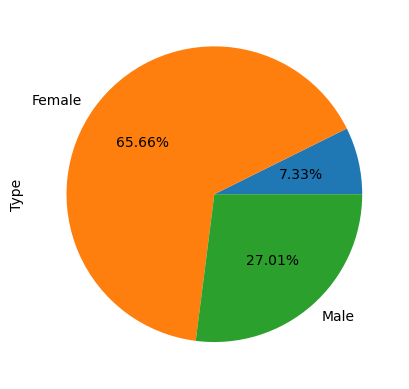

In [18]:
data1.groupby('Gender').size().plot(kind='pie',y ='Gender',label='Type',autopct='%1.2f%%') 

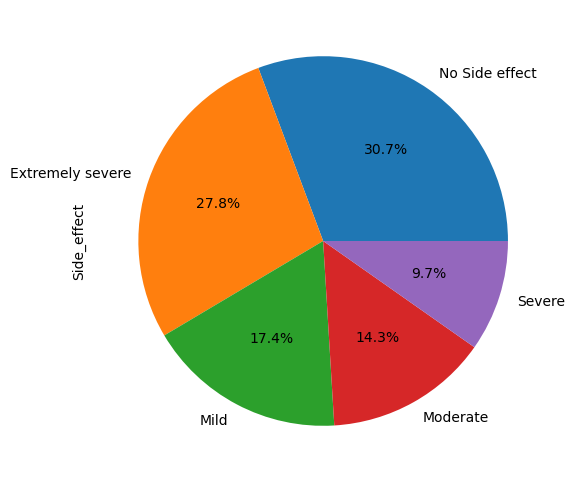

In [19]:
plt.figure(figsize=(6,6))
data1['Side_effect'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [20]:
data1['Gender'].unique()

array(['Male', 'Female', ' '], dtype=object)

Checking for null values

In [21]:
data1.isna().sum()

Name              0
Race              0
Age               0
Condition         0
Date              0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          42
Satisfaction      0
Gender            0
Sides             0
UsefulCount       0
Side_effect       4
dtype: int64

In [22]:
# Nan rows were dropped
data1.dropna(axis = 0, inplace = True)

In [23]:
data1.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Gender           0
Sides            0
UsefulCount      0
Side_effect      0
dtype: int64

In [24]:
# Handling instances with whitespaces
for i in data1:
    data1[i]=np.where(data1[i]==" ",np.NAN,data1[i])
    

In [25]:
data1.isna().sum()

Name                 0
Race                 0
Age              13454
Condition           47
Date                 0
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews          46141
Satisfaction         0
Gender           29307
Sides            19190
UsefulCount          0
Side_effect          0
dtype: int64

In [26]:
# Converting the date into date time format
data1['Date'] = pd.to_datetime(data1['Date'])

In [27]:
data1.Age.value_counts()

45-54         88110
55-64         82789
35-44         60702
25-34         54908
65-74         45522
19-24         26689
75 or over    16758
13-18          7764
7-12           1793
3-6             917
0-2             548
Name: Age, dtype: int64

In [28]:
data1.Gender.value_counts()

Female    262618
Male      108029
Name: Gender, dtype: int64

In [29]:
data1.Race.value_counts()

White              239461
Hispanic            76248
Black               51963
Asian               24184
Other                4073
American Indian      4025
Name: Race, dtype: int64

In [30]:
data1.Drug.value_counts()

cymbalta                                5113
lisinopril                              4738
lisinopril solution                     4724
lexapro                                 4564
hydrocodone-acetaminophen               4361
                                        ... 
acidophilus probiotic                      1
acid green 50 (bulk) 100 % powder          1
acetylcyst-mecobal-l-mefolate tablet       1
acetylcholine chloride kit                 1
vanadium granules                          1
Name: Drug, Length: 7093, dtype: int64

In [31]:
cymbalta = data1[data1['Drug'] == 'cymbalta']
cymbalta.head(10)

Name      Race    Age                               Condition  \
314212      Archie     White   7-12               Major Depressive Disorder   
314216  Georgianne     White  45-54            Repeated Episodes of Anxiety   
314223        Josh  Hispanic  45-54  Anxiousness associated with Depression   
314235        Suzi     White  35-44  Anxiousness associated with Depression   
314246     Margert     Black  55-64             Chronic Muscle or Bone Pain   
314257     Cristin     White  55-64  Anxiousness associated with Depression   
314267     Gaylord     White  45-54             Chronic Muscle or Bone Pain   
314281       Moshe     White  19-24               Major Depressive Disorder   
314292       Alvin     Black  45-54  Anxiousness associated with Depression   
314305        Bret     White  55-64             Chronic Muscle or Bone Pain   

             Date      Drug   DrugId  EaseofUse  Effectiveness  \
314212 2020-02-29  cymbalta  91491.0        5.0            5.0   
314216 2020-01-13  cymbalta  91491.0        3.0            1.0   
314223 2020-01-04  cymbalta  91491.0        5.0            5.0   
314235 2019-12-06  cymbalta  91491.0        3.0            3.0   
314246 2019-11-20  cymbalta  91491.0        2.0            2.0   
314257 2019-11-19  cymbalta  91491.0        3.0            3.0   
314267 2019-11-09  cymbalta  91491.0        5.0            4.0   
314281 2019-09-29  cymbalta  91491.0        2.0            1.0   
314292 2019-09-22  cymbalta  91491.0        1.0            1.0   
314305 2019-09-18  cymbalta  91491.0        5.0            4.0   

                                                  Reviews  Satisfaction  \
314212  No Script or health Insurance needed to place ...           5.0   
314216  I was prescribed Cymbalta for anxiety and star...           1.0   
314223  Switched from Effexor to this medicine after 1...           5.0   
314235  Bipolar I with a neck fusion. Pdoc prescribed ...           2.0   
314246  I have depression, anxiety, Fibro, severe musc...           2.0   
314257  Cymbalta was prescribed for depression.  I als...           1.0   
314267  I have only had one 30mg and so far i noticed ...           4.0   
314281                                                NaN           1.0   
314292  I've been on Cymbalta (generic) for approx a y...           1.0   
314305  The biggest problem was impotency from this pi...           4.0   

        Gender                                              Sides  \
314212     NaN  Nausea ,  dry mouth ,  constipation , loss of ...   
314216    Male  Nausea ,  dry mouth ,  constipation , loss of ...   
314223     NaN  Nausea ,  dry mouth ,  constipation , loss of ...   
314235  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314246     NaN  Nausea ,  dry mouth ,  constipation , loss of ...   
314257     NaN  Nausea ,  dry mouth ,  constipation , loss of ...   
314267  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314281    Male  Nausea ,  dry mouth ,  constipation , loss of ...   
314292     NaN  Nausea ,  dry mouth ,  constipation , loss of ...   
314305    Male  Nausea ,  dry mouth ,  constipation , loss of ...   

        UsefulCount       Side_effect  
314212         12.0    No Side effect  
314216          0.0  Extremely severe  
314223          0.0    No Side effect  
314235          0.0            Severe  
314246          1.0            Severe  
314257          1.0  Extremely severe  
314267          0.0              Mild  
314281          2.0  Extremely severe  
314292          0.0  Extremely severe  
314305          0.0              Mild

In [32]:
selected = data1[['Drug','DrugId']]
selected

Drug    DrugId
0                       25dph-7.5peh  146724.0
1                       25dph-7.5peh  146724.0
2       warfarin (bulk) 100 % powder  144731.0
3       warfarin (bulk) 100 % powder  144731.0
4       warfarin (bulk) 100 % powder  144731.0
...                              ...       ...
399995                       savella  152224.0
399996                     ibuprofen    5166.0
399997   betamethasone valerate foam    4897.0
399998                       lexapro   63990.0
399999                        femara    4363.0

[399954 rows x 2 columns]

In [33]:
data1.Effectiveness.value_counts()

5.0    143545
4.0     90273
3.0     66647
1.0     65466
2.0     34023
Name: Effectiveness, dtype: int64

In [34]:
data1.Satisfaction.value_counts()

5.0    122810
1.0    111314
4.0     69682
3.0     57165
2.0     38983
Name: Satisfaction, dtype: int64

In [35]:
data1.Condition.value_counts()

Other                                                                          54931
Pain                                                                           27858
High Blood Pressure                                                            25661
Depression                                                                     15982
Birth Control                                                                  13524
                                                                               ...  
PD-L1 positive adenocarcinoma of gastroesophageal junction                         1
Blood Clotting Protein Deficiency due to Anticoagulants                            1
Prevention of Cytomegalovirus Disease After Kidney-Pancreas Transplantation        1
Infection From Birth due to Toxoplasma Gondii Parasite                             1
Generalized Lipodystrophy                                                          1
Name: Condition, Length: 1804, dtype: int64

In [36]:
# drop 'Other' condition from dataset as other condition does not have any meaning
data1=data1.drop(labels=data1[data1.Condition=='Other'].index,axis=0)

In [37]:
#Missing value imputation for categorical value
#Get the object columns
data1['Age']=data1['Age'].fillna(data1['Age'].mode()[0])
data1['Condition']=data1['Condition'].fillna(data1['Condition'].mode()[0])
data1['Reviews']=data1['Reviews'].fillna(data1['Reviews'].mode()[0])
data1['Gender']=data1['Gender'].fillna(data1['Gender'].mode()[0])
data1['Side_effect']=data1['Side_effect'].fillna(data1['Side_effect'].mode()[0])

print (" Mode for Age column\n",data1['Age'].mode())
print (" \nMode for Condition column\n",data1['Condition'].mode())
print (" \nMode for Reviews column\n",data1['Reviews'].mode())
print (" \nMode for Gender column\n",data1['Gender'].mode())
print (" \nMode for Side effect column\n",data1['Side_effect'].mode())

 Mode for Age column
 0    45-54
Name: Age, dtype: object
 
Mode for Condition column
 0    Pain
Name: Condition, dtype: object
 
Mode for Reviews column
 0    this treatment is awsome.  I love drugs.
Name: Reviews, dtype: object
 
Mode for Gender column
 0    Female
Name: Gender, dtype: object
 
Mode for Side effect column
 0    No Side effect
Name: Side_effect, dtype: object


In [38]:
data1.shape

(345023, 15)

In [39]:
data1.isna().sum()

Name                 0
Race                 0
Age                  0
Condition            0
Date                 0
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews              0
Satisfaction         0
Gender               0
Sides            12049
UsefulCount          0
Side_effect          0
dtype: int64

In [40]:
data1.nunique()

Name               3323
Race                  6
Age                  11
Condition          1803
Date               4523
Drug               5641
DrugId             5135
EaseofUse             5
Effectiveness         5
Reviews          214423
Satisfaction          5
Gender                2
Sides              1594
UsefulCount         147
Side_effect           5
dtype: int64

In [41]:
print("unique values in age column:\n",data1['Age'].unique())
print("\n unique values in age column:\n",data1['Race'].unique())
print("\n unique values in Gender column:\n",data1['Gender'].unique())
print("\n unique values in Satisfaction column:\n",data1['Satisfaction'].unique())
print("\n unique values in Effectiveness column:\n",data1['Effectiveness'].unique())
print("\n unique values in UsefulCount column:\n",data1['UsefulCount'].unique())
print("\n unique values in EaseofUse column:\n",data1['EaseofUse'].unique())
print("\n unique values in Drug column:\n",data1['Drug'].unique())
print("\n unique values in Condition column:\n",data1['Condition'].unique())
print("\n unique values in Side effect column:\n",data1['Side_effect'].unique())
print("\n unique values in Reviews column:\n",data1['Reviews'].unique())

unique values in age column:
 ['75 or over' '25-34' '45-54' '55-64' '19-24' '35-44' '13-18' '65-74'
 '7-12' '0-2' '3-6']

 unique values in age column:
 ['Hispanic' 'White' 'Black' 'Asian' 'American Indian' 'Other']

 unique values in Gender column:
 ['Male' 'Female']

 unique values in Satisfaction column:
 [5. 2. 1. 4. 3.]

 unique values in Effectiveness column:
 [5. 2. 1. 3. 4.]

 unique values in UsefulCount column:
 [  0.   1.   3.  10.   5.   4.   2.   7.   6.  12.  15.   9.  14.  13.
  18.  29.  17.   8.  30.  20.  16.  25.  19.  11.  23.  38.  44.  34.
  35.  21.  42.  28.  36.  40.  60.  48.  61.  50.  43.  26.  22.  41.
  54.  24.  33.  27.  45.  59.  77.  66.  31.  47.  32.  90.  84.  39.
  55. 137.  53.  56.  65.  46.  37.  74.  49.  63.  57.  71.  51.  67.
 105.  58.  62.  52.  70. 113.  83. 140.  88. 100. 107.  79.  96.  72.
  97.  64.  87.  76.  68. 131. 101.  69. 108. 154.  81.  75. 109. 112.
  82. 136.  80. 117. 103.  86.  73.  92. 133.  85. 119. 141. 123.  78.
  89. 

Make columns Year, Month and Day of the week from Date column

In [42]:
data1['Year'] = pd.to_datetime(data1['Date'], errors='coerce').dt.year
data1['Month'] = pd.to_datetime(data1['Date'], errors='coerce').dt.month
data1['day_of_the_week'] = pd.to_datetime(data1['Date'], errors='coerce').dt.day_name()

In [43]:
data1.head()

Name      Race         Age                      Condition       Date  \
0   James  Hispanic  75 or over                    Stuffy Nose 2014-09-21   
1    Ross     White       25-34                  Cold Symptoms 2011-01-13   
6      Ta     White       25-34                  Birth Control 2017-06-15   
7  Duncan     White       45-54  Disease of Ovaries with Cysts 2017-01-30   
8    Hang     White       25-34                           Acne 2016-04-27   

           Drug    DrugId  EaseofUse  Effectiveness  \
0  25dph-7.5peh  146724.0        5.0            5.0   
1  25dph-7.5peh  146724.0        5.0            5.0   
6     wymzya fe  163180.0        5.0            5.0   
7     wymzya fe  163180.0        5.0            5.0   
8     wymzya fe  163180.0        4.0            2.0   

                                             Reviews  Satisfaction  Gender  \
0  I'm a retired physician and of all the meds I ...           5.0    Male   
1  cleared me right up even with my throat hurtin...           5.0  Female   
6  Haven't gotten pregnant so it does it's job. I...           2.0  Female   
7  I have take this for 5 years age 45-50 to prev...           5.0  Female   
8           this treatment is awsome.  I love drugs.           2.0  Female   

                                               Sides  UsefulCount  \
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...          0.0   
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...          1.0   
6  Nausea ,  vomiting ,  headache ,  bloating ,  ...          0.0   
7  Nausea ,  vomiting ,  headache ,  bloating ,  ...          0.0   
8  Nausea ,  vomiting ,  headache ,  bloating ,  ...          1.0   

      Side_effect  Year  Month day_of_the_week  
0  No Side effect  2014      9          Sunday  
1  No Side effect  2011      1        Thursday  
6          Severe  2017      6        Thursday  
7  No Side effect  2017      1          Monday  
8          Severe  2016      4       Wednesday

Checking for duplicate rows

In [44]:
print(f"Duplicates: {data1.duplicated().sum()}")
duplicate = data1[data1.duplicated()]
print("Duplicate Rows :")
# Print the resultant rows
duplicate

Duplicates: 4
Duplicate Rows :


Name      Race    Age                  Condition       Date  \
370447  Christian     White  45-54  Major Depressive Disorder 2012-06-24   
389725     Pamila     White  19-24                 Depression 2010-05-20   
396704      Heike     White  25-34              Cold Symptoms 2011-01-13   
399854    Matthew  Hispanic  65-74        High Blood Pressure 2010-04-02   

                       Drug    DrugId  EaseofUse  Effectiveness  \
370447              viibryd  155880.0        5.0            3.0   
389725               prozac    6997.0        5.0            4.0   
396704         25dph-7.5peh  146724.0        5.0            5.0   
399854  amlodipine besylate    5891.0        2.0            1.0   

                                                  Reviews  Satisfaction  \
370447  Found out that taking Viibryd after lunch work...           2.0   
389725  I took Prozac (Fluoxetine) for Depression/Bipo...           5.0   
396704  cleared me right up even with my throat hurtin...           5.0   
399854           Not as good as the brand name "Norvasc".           1.0   

        Gender                                              Sides  \
370447  Female  Diarrhea ,  nausea ,  vomiting ,  dizziness , ...   
389725  Female  Nausea , drowsiness,  dizziness ,  anxiety ,  ...   
396704  Female  Drowsiness,  dizziness ,  dry mouth /nose/thro...   
399854    Male  Dizziness ,  lightheadedness , swelling  ankle...   

        UsefulCount       Side_effect  Year  Month day_of_the_week  
370447          8.0            Severe  2012      6          Sunday  
389725         18.0    No Side effect  2010      5        Thursday  
396704          1.0    No Side effect  2011      1        Thursday  
399854          6.0  Extremely severe  2010      4          Friday

In [45]:
# drop duplicated row
data1.drop_duplicates(inplace=True, keep='first')

In [46]:
data1.shape

(345019, 18)

In [47]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345019 entries, 0 to 399999
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Name             345019 non-null  object        
 1   Race             345019 non-null  object        
 2   Age              345019 non-null  object        
 3   Condition        345019 non-null  object        
 4   Date             345019 non-null  datetime64[ns]
 5   Drug             345019 non-null  object        
 6   DrugId           345019 non-null  float64       
 7   EaseofUse        345019 non-null  float64       
 8   Effectiveness    345019 non-null  float64       
 9   Reviews          345019 non-null  object        
 10  Satisfaction     345019 non-null  float64       
 11  Gender           345019 non-null  object        
 12  Sides            332970 non-null  object        
 13  UsefulCount      345019 non-null  float64       
 14  Side_effect      345

Checking the number of patients given rating 1 to 5 for satisfaction,effectiveness and ease of use

In [48]:
satisfiction_count=data1['Satisfaction'].value_counts()
effectiveness_count=data1['Effectiveness'].value_counts()
ease_of_use_count=data1['EaseofUse'].value_counts()
li = [0,1,2,3,4,5]
Rating = pd.Series(li)
value_count=pd.concat([Rating ,satisfiction_count,effectiveness_count,ease_of_use_count],axis=1)
value_count.rename(columns = {0:'Rating','Satisfaction':'satisfiction_count','Effectiveness':'effectiveness_count','EaseofUse':'ease_of_use_count'}, inplace = True)

In [49]:
value_count

Rating  satisfiction_count  effectiveness_count  ease_of_use_count
0.0       0                 NaN                  NaN                NaN
1.0       1             94048.0              53799.0            32586.0
2.0       2             34039.0              29423.0            17136.0
3.0       3             49869.0              57970.0            39182.0
4.0       4             61102.0              79202.0            71891.0
5.0       5            105961.0             124625.0           184224.0

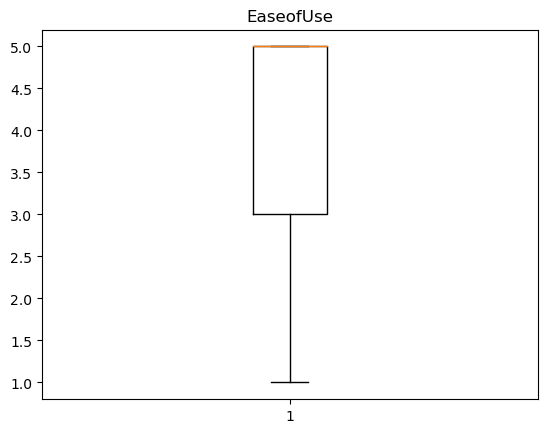

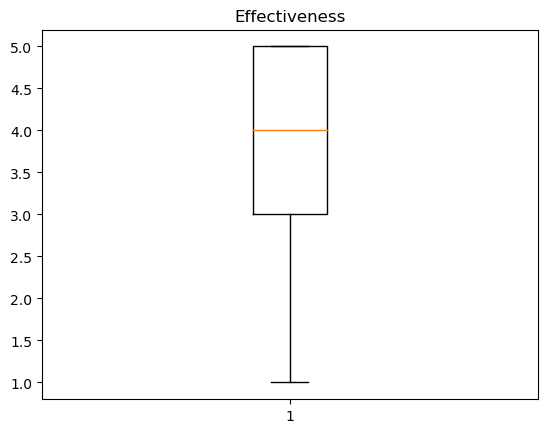

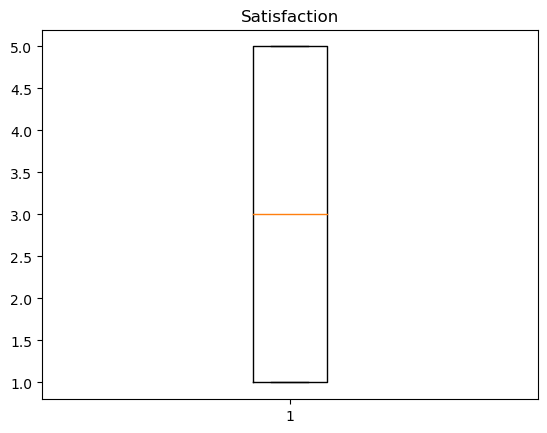

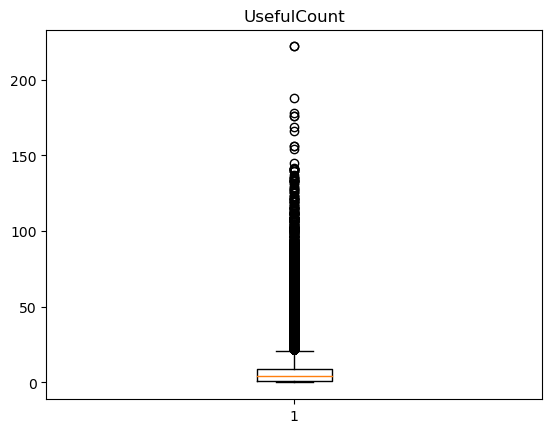

In [50]:
#Boxplot for numerical columns to check outliers
for i in ['EaseofUse','Effectiveness','Satisfaction','UsefulCount']:
    plt.figure()
    plt.boxplot(data1[i])
    plt.title(i)

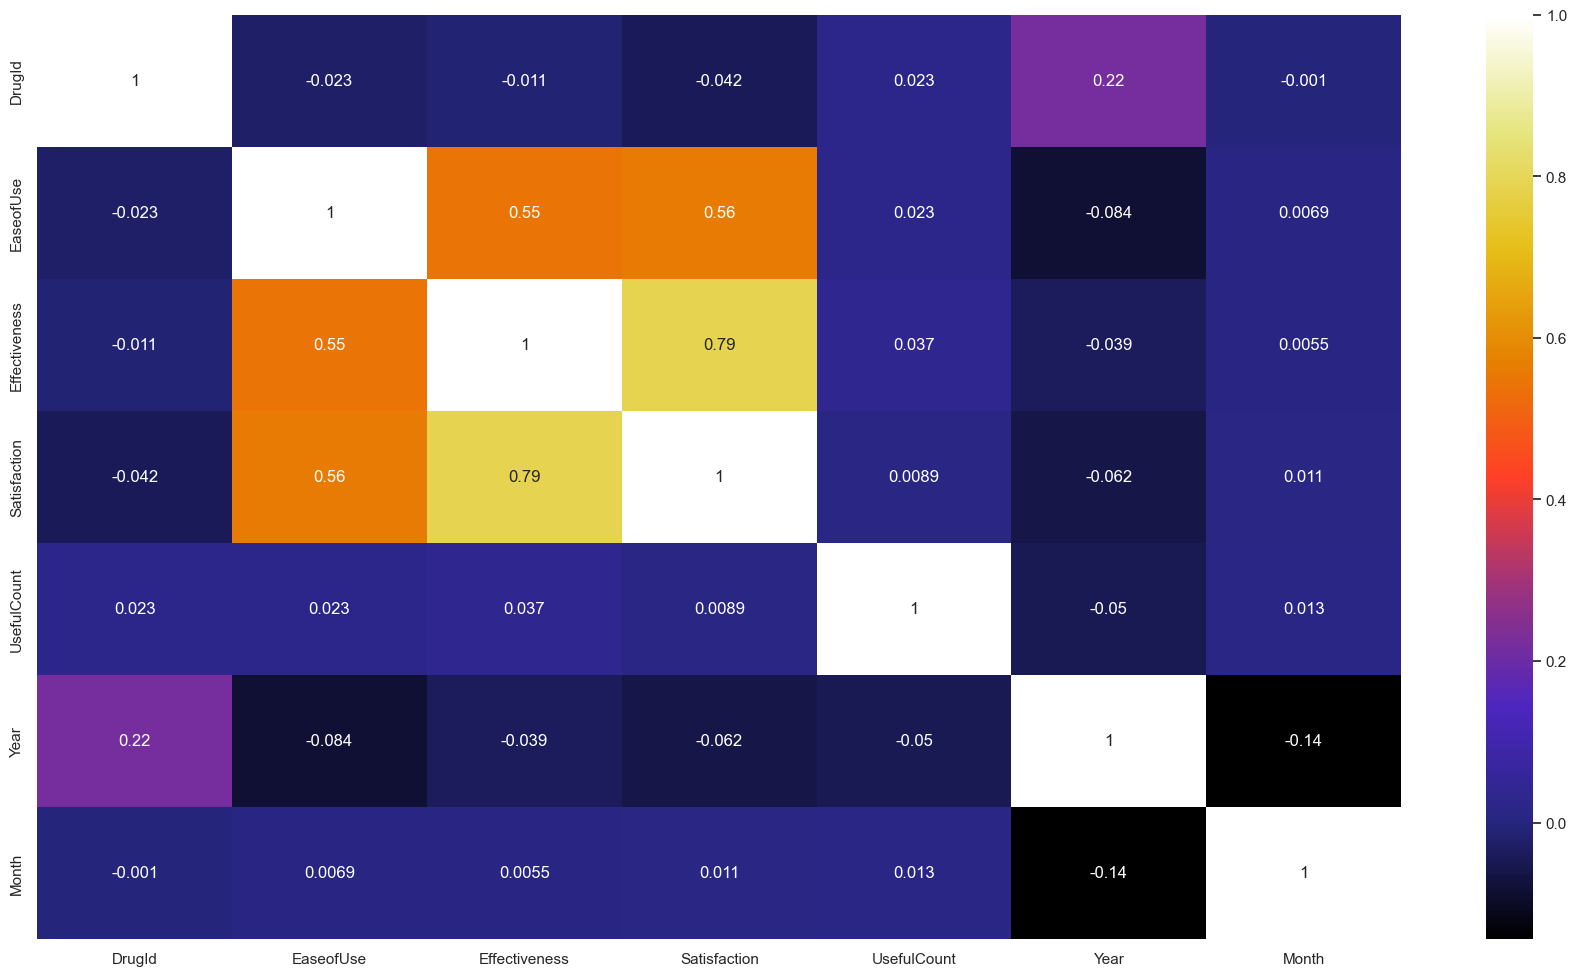

In [51]:
#Bivariate analysis 
#Correlation plot using heatmap
def plot_corr(data):
    corr = data.corr()
    sns.set_theme()
    plt.figure(figsize = (22,12))
    sns.heatmap(corr, cbar=True, annot=True, cmap='CMRmap')
plot_corr(data1)

In [52]:
#To treat outliers
Q1 = data1.UsefulCount.quantile(0.25)
Q3 = data1.UsefulCount.quantile(0.75)
IQR = Q3 - Q1
min_limit = Q1 - (IQR * 1.5)
max_limit = Q3 + (IQR * 1.5)
print(min_limit, max_limit,IQR)

-11.0 21.0 8.0


In [53]:
data1.loc[data1.UsefulCount > max_limit]

Name   Race         Age  \
82       Vannesa  White       25-34   
94          Otha  Black       45-54   
140       Julius  White       45-54   
146      Dierdre  White       35-44   
165     Kristeen  White       35-44   
...          ...    ...         ...   
399934  Chassidy  Black  75 or over   
399942    Chance  White       19-24   
399990     Carey  Black       45-54   
399991   Laurice  White       45-54   
399999     Miles  Black       55-64   

                                                Condition       Date  \
82                       Abnormally Long or Heavy Periods 2012-06-30   
94                       Abnormally Long or Heavy Periods 2012-03-11   
140                      Abnormally Long or Heavy Periods 2011-07-01   
146                      Abnormally Long or Heavy Periods 2011-03-30   
165                      Abnormally Long or Heavy Periods 2010-11-28   
...                                                   ...        ...   
399934                                Atrial Fibrillation 2016-01-22   
399942                                               Pain 2010-07-27   
399990                                         Depression 2017-01-21   
399991         Mild to Moderate Alzheimer's Type Dementia 2012-09-25   
399999  Hormone Receptor Positive Postmenopausal Early... 2009-07-11   

                  Drug    DrugId  EaseofUse  Effectiveness  \
82             lysteda  154120.0        4.0            3.0   
94             lysteda  154120.0        1.0            1.0   
140            lysteda  154120.0        5.0            5.0   
146            lysteda  154120.0        5.0            4.0   
165            lysteda  154120.0        5.0            5.0   
...                ...       ...        ...            ...   
399934  amiodarone hcl    4521.0        5.0            5.0   
399942   methadone hcl    2671.0        5.0            5.0   
399990         lexapro   63990.0        4.0            4.0   
399991   donepezil hcl   14334.0        5.0            4.0   
399999          femara    4363.0        5.0            3.0   

                                                  Reviews  Satisfaction  \
82      I had heavy periods most of my adult life. Lar...           1.0   
94      my 44 year old sister is in the neuro ICU from...           1.0   
140     Due to fibroids, I have had 2 days a month of ...           5.0   
146     I can not say enough good things about Lysteda...           5.0   
165     Trying to be thorough for those who are wonder...           5.0   
...                                                   ...           ...   
399934  My a-fibs stopped immediately after two other ...           5.0   
399942  After being on vicodin for 2 1/2 years, taking...           5.0   
399990  Starting taking Prozac and didn't help, switch...           5.0   
399991  my mom just started taking this medicine,i,see...           4.0   
399999  I too have had joint pain taking this....all i...           1.0   

        Gender                                              Sides  \
82      Female  Nausea ,  vomiting ,  diarrhea , and  muscle p...   
94      Female  Nausea ,  vomiting ,  diarrhea , and  muscle p...   
140     Female  Nausea ,  vomiting ,  diarrhea , and  muscle p...   
146     Female  Nausea ,  vomiting ,  diarrhea , and  muscle p...   
165     Female  Nausea ,  vomiting ,  diarrhea , and  muscle p...   
...        ...                                                ...   
399934  Female  Nausea ,  vomiting ,  constipation , loss of a...   
399942  Female  Nausea ,  vomiting ,  constipation ,  lighthea...   
399990  Female  Nausea ,  dry mouth ,  trouble sleeping ,  con...   
399991  Female  Nausea ,  vomiting ,  diarrhea , loss of appet...   
399999  Female  Hot flashes ,  hair loss ,  joint /bone/ muscl...   

        UsefulCount       Side_effect  Year  Month day_of_the_week  
82             29.0  Extremely severe  2012      6        Saturday  
94             30.0  Extremely severe  2012      3          Sunda

In [54]:
data1.loc[data1.UsefulCount<min_limit]

Empty DataFrame
Columns: [Name, Race, Age, Condition, Date, Drug, DrugId, EaseofUse, Effectiveness, Reviews, Satisfaction, Gender, Sides, UsefulCount, Side_effect, Year, Month, day_of_the_week]
Index: []

In [55]:
data1.loc[data1['UsefulCount']>max_limit,'UsefulCount']=np.mean(data1.UsefulCount)

In [56]:
data1.loc[data1.UsefulCount > max_limit]

Empty DataFrame
Columns: [Name, Race, Age, Condition, Date, Drug, DrugId, EaseofUse, Effectiveness, Reviews, Satisfaction, Gender, Sides, UsefulCount, Side_effect, Year, Month, day_of_the_week]
Index: []

In [57]:
data1.head()

Name      Race         Age                      Condition       Date  \
0   James  Hispanic  75 or over                    Stuffy Nose 2014-09-21   
1    Ross     White       25-34                  Cold Symptoms 2011-01-13   
6      Ta     White       25-34                  Birth Control 2017-06-15   
7  Duncan     White       45-54  Disease of Ovaries with Cysts 2017-01-30   
8    Hang     White       25-34                           Acne 2016-04-27   

           Drug    DrugId  EaseofUse  Effectiveness  \
0  25dph-7.5peh  146724.0        5.0            5.0   
1  25dph-7.5peh  146724.0        5.0            5.0   
6     wymzya fe  163180.0        5.0            5.0   
7     wymzya fe  163180.0        5.0            5.0   
8     wymzya fe  163180.0        4.0            2.0   

                                             Reviews  Satisfaction  Gender  \
0  I'm a retired physician and of all the meds I ...           5.0    Male   
1  cleared me right up even with my throat hurtin...           5.0  Female   
6  Haven't gotten pregnant so it does it's job. I...           2.0  Female   
7  I have take this for 5 years age 45-50 to prev...           5.0  Female   
8           this treatment is awsome.  I love drugs.           2.0  Female   

                                               Sides  UsefulCount  \
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...          0.0   
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...          1.0   
6  Nausea ,  vomiting ,  headache ,  bloating ,  ...          0.0   
7  Nausea ,  vomiting ,  headache ,  bloating ,  ...          0.0   
8  Nausea ,  vomiting ,  headache ,  bloating ,  ...          1.0   

      Side_effect  Year  Month day_of_the_week  
0  No Side effect  2014      9          Sunday  
1  No Side effect  2011      1        Thursday  
6          Severe  2017      6        Thursday  
7  No Side effect  2017      1          Monday  
8          Severe  2016      4       Wednesday

Which gender is the predominant user?

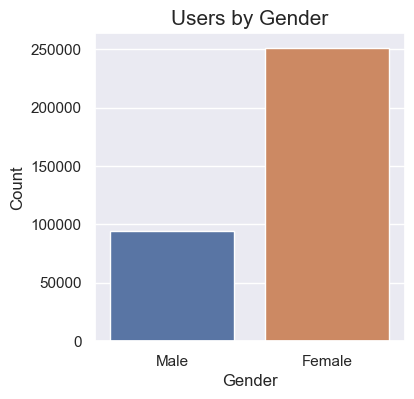

In [58]:
plt.figure(figsize = (4,4))
s=sns.countplot(x='Gender', data=data1)
plt.title('Users by Gender', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Count') 
plt.show()

Female users are predominant

Which race is the predominant user?

Text(0, 0.5, 'Count')

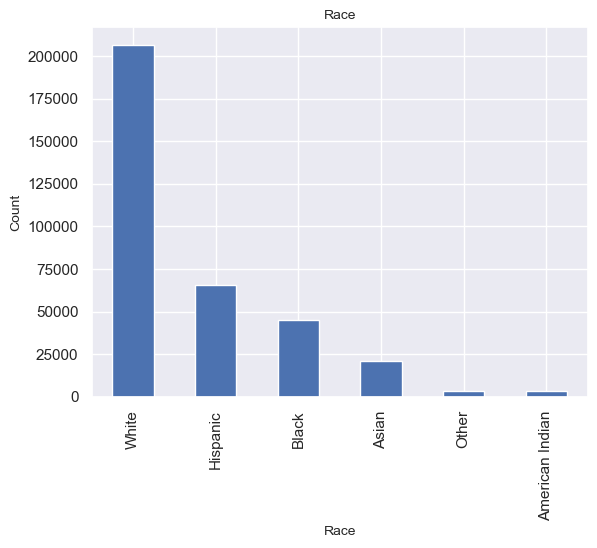

In [59]:
data1['Race'].value_counts().plot(kind='bar')
plt.title("Race", fontsize = 10)
plt.xlabel("Race", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

which age group is the predominant user?

Text(0, 0.5, 'count')

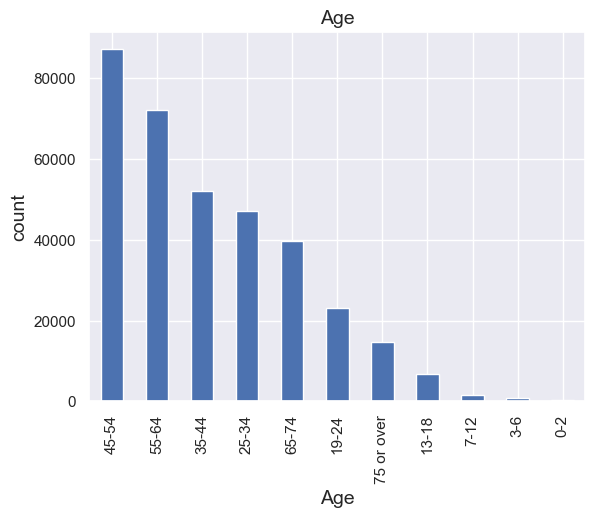

In [60]:
data1['Age'].value_counts().plot(kind='bar')
plt.title("Age", fontsize = 14)
plt.xlabel("Age", fontsize = 14)
plt.ylabel("count", fontsize = 14)

In each race, which gender is the predominant user?

Text(0.5, 1.0, 'Users by Race and Gender')

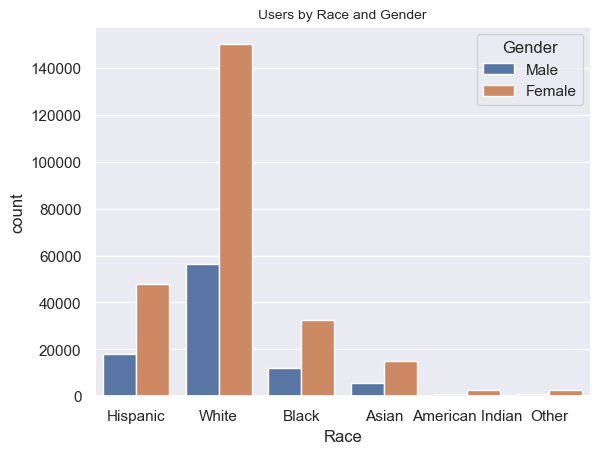

In [61]:
sns.countplot(x='Race',hue='Gender',data=data1)
plt.title("Users by Race and Gender", fontsize = 10)

In each age group, which gender is the predominant user?

Text(0.5, 1.0, 'Users by Age and Gender')

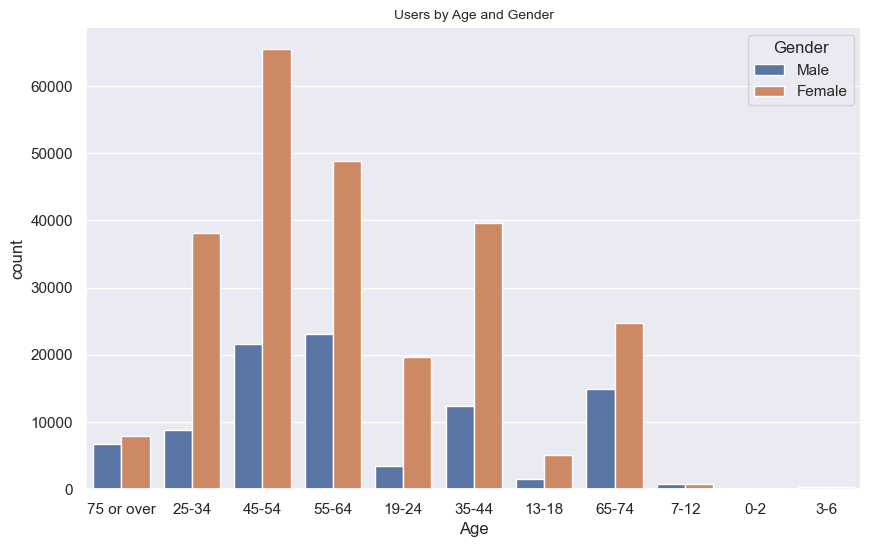

In [62]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Gender',data=data1)
plt.title("Users by Age and Gender", fontsize = 10)

How many drugs do we have?

In [63]:
Num = len(data1['Drug'].unique().tolist())
print('The Total number of Drugs are -',Num )

The Total number of Drugs are - 5641


What is the most popular drug?

In [64]:
data1['Drug'].value_counts().nlargest(20)

lisinopril                                             4620
lisinopril solution                                    4597
cymbalta                                               4548
lexapro                                                4278
hydrocodone-acetaminophen                              4220
effexor xr                                             3641
tramadol hcl                                           3067
tramadol hcl er                                        3043
zoloft                                                 2650
lyrica                                                 2592
phentermine hcl                                        2493
prednisone                                             2432
prednisone concentrate                                 2415
prednisone tablet, delayed release (enteric coated)    2402
celexa                                                 2308
trazodone hcl                                          2151
seroquel                                

Top 20 Drugs used

Text(0, 0.5, 'Count of Drugs')

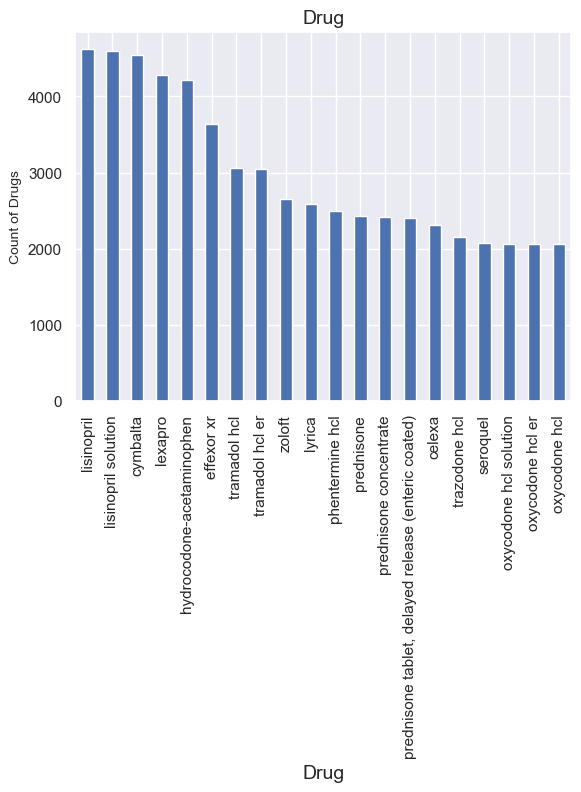

In [65]:
data1['Drug'].value_counts().nlargest(20).plot(kind='bar')
plt.title("Drug", fontsize = 14)
plt.xlabel("Drug", fontsize = 14)
plt.ylabel("Count of Drugs", fontsize = 10)

Common drug is Lisinopril and used for high blood pressure 

In each year, how many reviews were collected?

Text(0, 0.5, 'Count of Reviews')

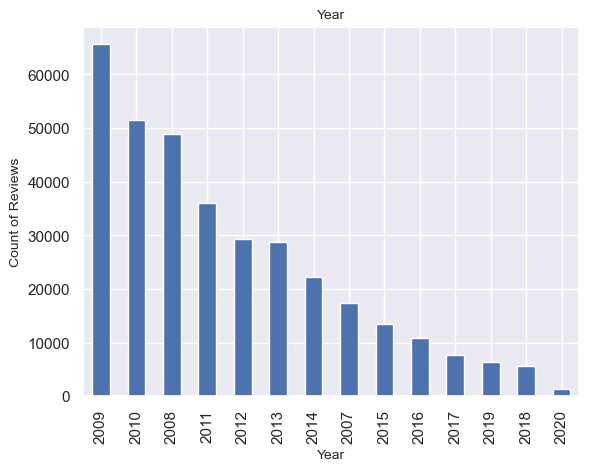

In [66]:
data1['Year'].value_counts().plot(kind='bar')
plt.title("Year", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Count of Reviews", fontsize = 10)

In each year, there is a gradual decrease in user reviews

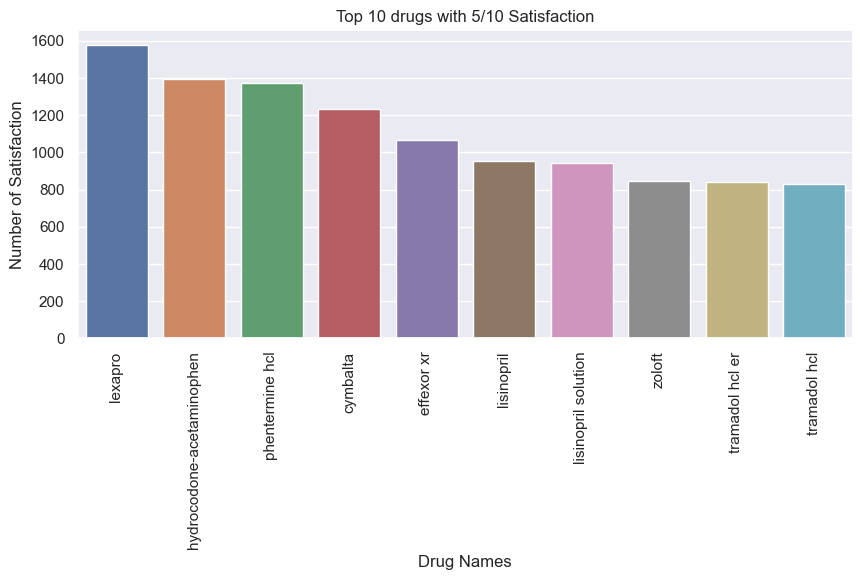

In [67]:
# This barplot shows the top 10 drugs with the 5/10 Satisfaction ratings
# Setting the Parameter
sns.set(font_scale = 1.0, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

Satisfaction = dict(data1.loc[data1.Satisfaction == 5, "Drug"].value_counts())
drugname = list(Satisfaction.keys())
drug_Satisfaction = list(Satisfaction.values())

sns_Satisfaction = sns.barplot(x = drugname[0:10], y = drug_Satisfaction[0:10])
sns_Satisfaction.set_title('Top 10 drugs with 5/10 Satisfaction')
sns_Satisfaction.set_ylabel("Number of Satisfaction")
sns_Satisfaction.set_xlabel("Drug Names")
plt.setp(sns_Satisfaction.get_xticklabels(), rotation=90);

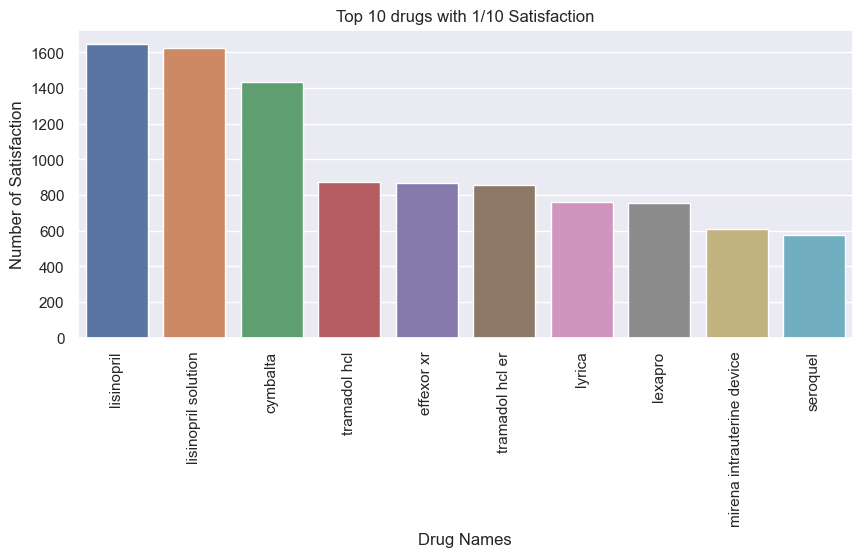

In [68]:
# This barplot shows the top 10 drugs with the 1/10 Satisfaction_ratings
# Setting the Parameter
sns.set(font_scale = 1.0, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

Satisfaction = dict(data1.loc[data1.Satisfaction == 1, "Drug"].value_counts())
drugname = list(Satisfaction.keys())
drug_Satisfaction = list(Satisfaction.values())

sns_Satisfaction = sns.barplot(x = drugname[0:10], y = drug_Satisfaction[0:10])

sns_Satisfaction.set_title('Top 10 drugs with 1/10 Satisfaction')
sns_Satisfaction.set_ylabel("Number of Satisfaction")
sns_Satisfaction.set_xlabel("Drug Names")
plt.setp(sns_Satisfaction.get_xticklabels(), rotation=90);

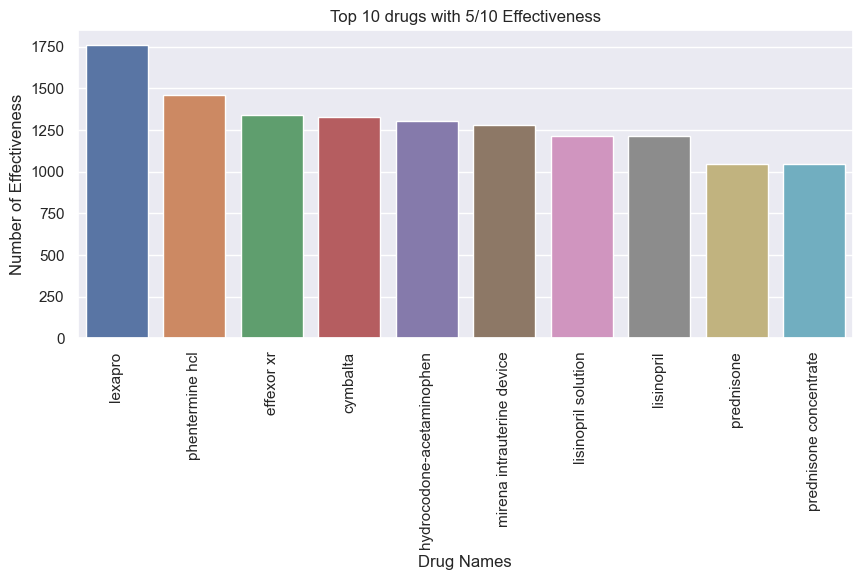

In [69]:
# This barplot shows the top 10 drugs with the 5/10 Effectiveness
# Setting the Parameter
sns.set(font_scale = 1.0, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

Effectiveness = dict(data1.loc[data1.Effectiveness == 5, "Drug"].value_counts())
drugname = list(Effectiveness.keys())
drug_Effectiveness = list(Effectiveness.values())

sns_Effectiveness = sns.barplot(x = drugname[0:10], y = drug_Effectiveness[0:10])

sns_Effectiveness.set_title('Top 10 drugs with 5/10 Effectiveness')
sns_Effectiveness.set_ylabel("Number of Effectiveness")
sns_Effectiveness.set_xlabel("Drug Names")
plt.setp(sns_Effectiveness.get_xticklabels(), rotation=90);

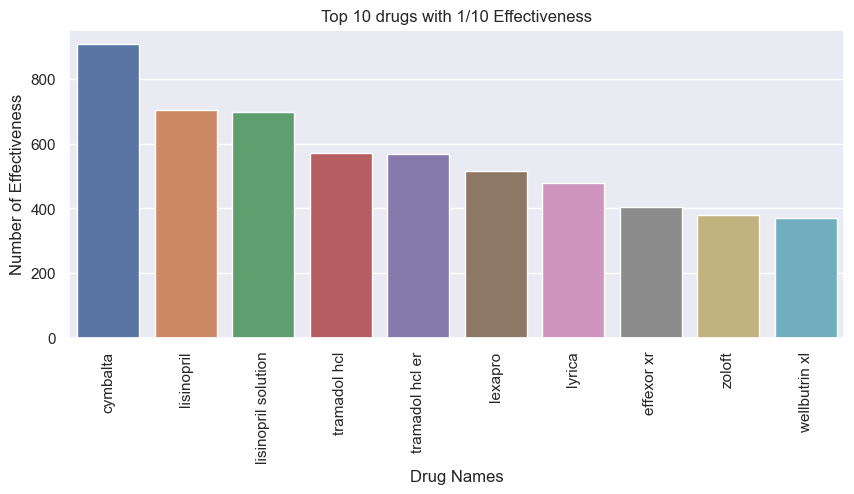

In [70]:
# This barplot shows the top 10 drugs with the 1/10 Effectiveness
# Setting the Parameter
sns.set(font_scale = 1.0, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

Effectiveness = dict(data1.loc[data1.Effectiveness == 1, "Drug"].value_counts())
drugname = list(Effectiveness.keys())
drug_Effectiveness = list(Effectiveness.values())

sns_Effectiveness = sns.barplot(x = drugname[0:10], y = drug_Effectiveness[0:10])

sns_Effectiveness.set_title('Top 10 drugs with 1/10 Effectiveness')
sns_Effectiveness.set_ylabel("Number of Effectiveness")
sns_Effectiveness.set_xlabel("Drug Names")
plt.setp(sns_Effectiveness.get_xticklabels(), rotation=90);

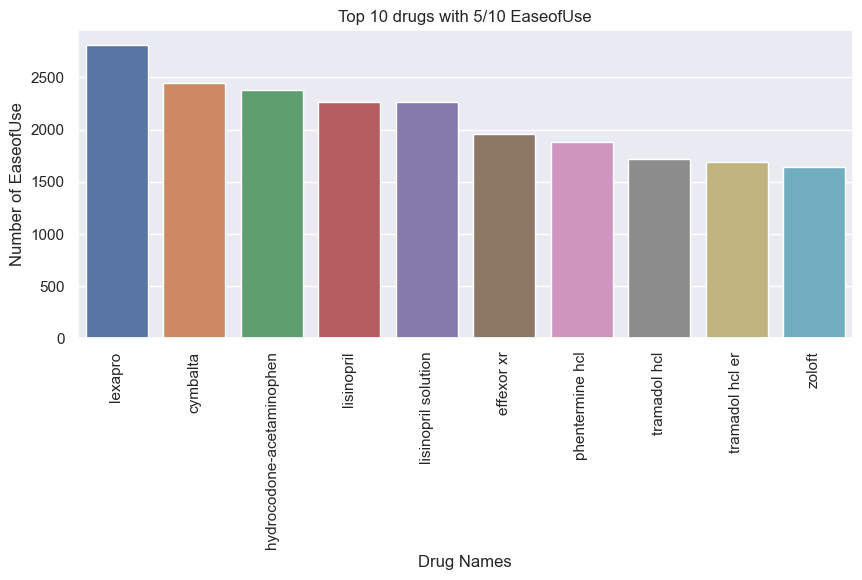

In [71]:
# This barplot shows the top 10 drugs with the 5/10 EaseofUse
# Setting the Parameter
sns.set(font_scale = 1.0, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

EaseofUse = dict(data1.loc[data1.EaseofUse == 5, "Drug"].value_counts())
drugname = list(EaseofUse.keys())
EaseofUse = list(EaseofUse.values())

sns_EaseofUse = sns.barplot(x = drugname[0:10], y = EaseofUse[0:10])

sns_EaseofUse.set_title('Top 10 drugs with 5/10 EaseofUse')
sns_EaseofUse.set_ylabel("Number of EaseofUse")
sns_EaseofUse.set_xlabel("Drug Names")
plt.setp(sns_EaseofUse.get_xticklabels(), rotation=90);

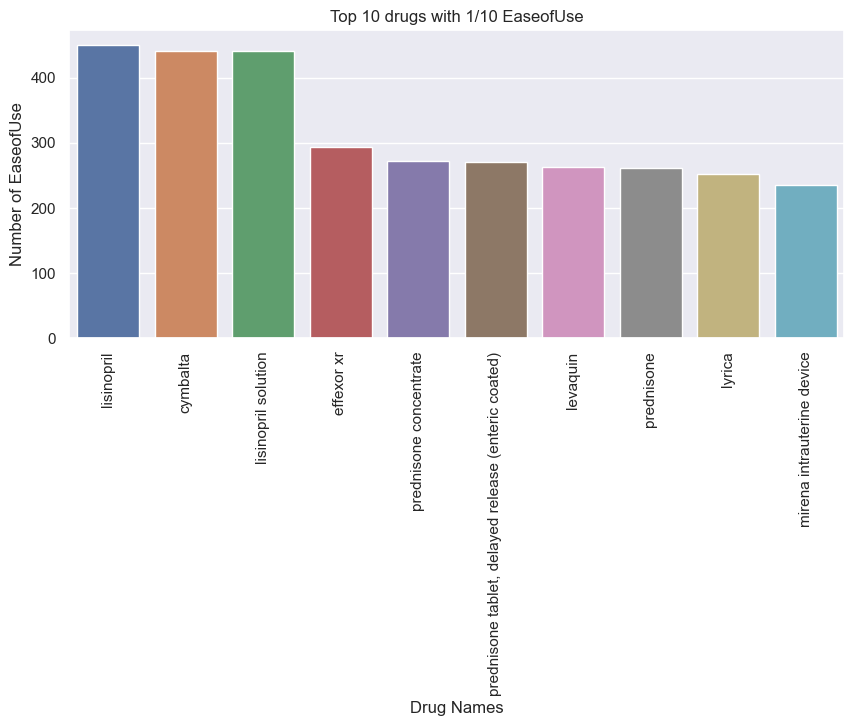

In [72]:
# This barplot shows the top 10 drugs with the 1/10 EaseofUse
# Setting the Parameter
sns.set(font_scale = 1.0, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

EaseofUse = dict(data1.loc[data1.EaseofUse == 1, "Drug"].value_counts())
drugname = list(EaseofUse.keys())
EaseofUse = list(EaseofUse.values())

sns_EaseofUse = sns.barplot(x = drugname[0:10], y = EaseofUse[0:10])

sns_EaseofUse.set_title('Top 10 drugs with 1/10 EaseofUse')
sns_EaseofUse.set_ylabel("Number of EaseofUse")
sns_EaseofUse.set_xlabel("Drug Names")
plt.setp(sns_EaseofUse.get_xticklabels(), rotation=90);

How many type of Drugs per condition (Top 10)

Text(0.5, 1.0, 'Highest no of unique drugs per condition')

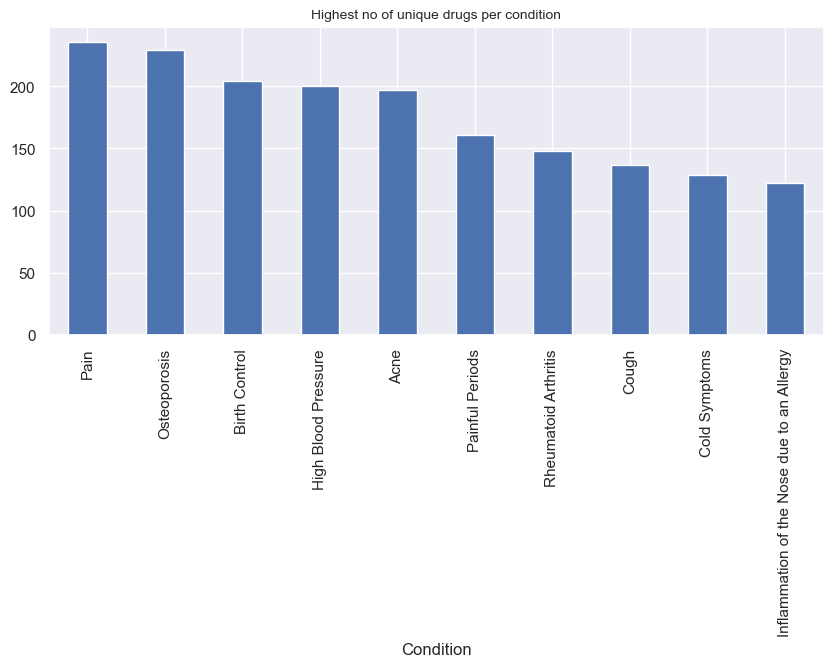

In [73]:
drug_cond = data1.groupby('Condition')['Drug'].nunique().nlargest(10).plot(kind='bar')

plt.title("Highest no of unique drugs per condition", fontsize = 10)

Text(0.5, 1.0, ' side effect with Symptoms')

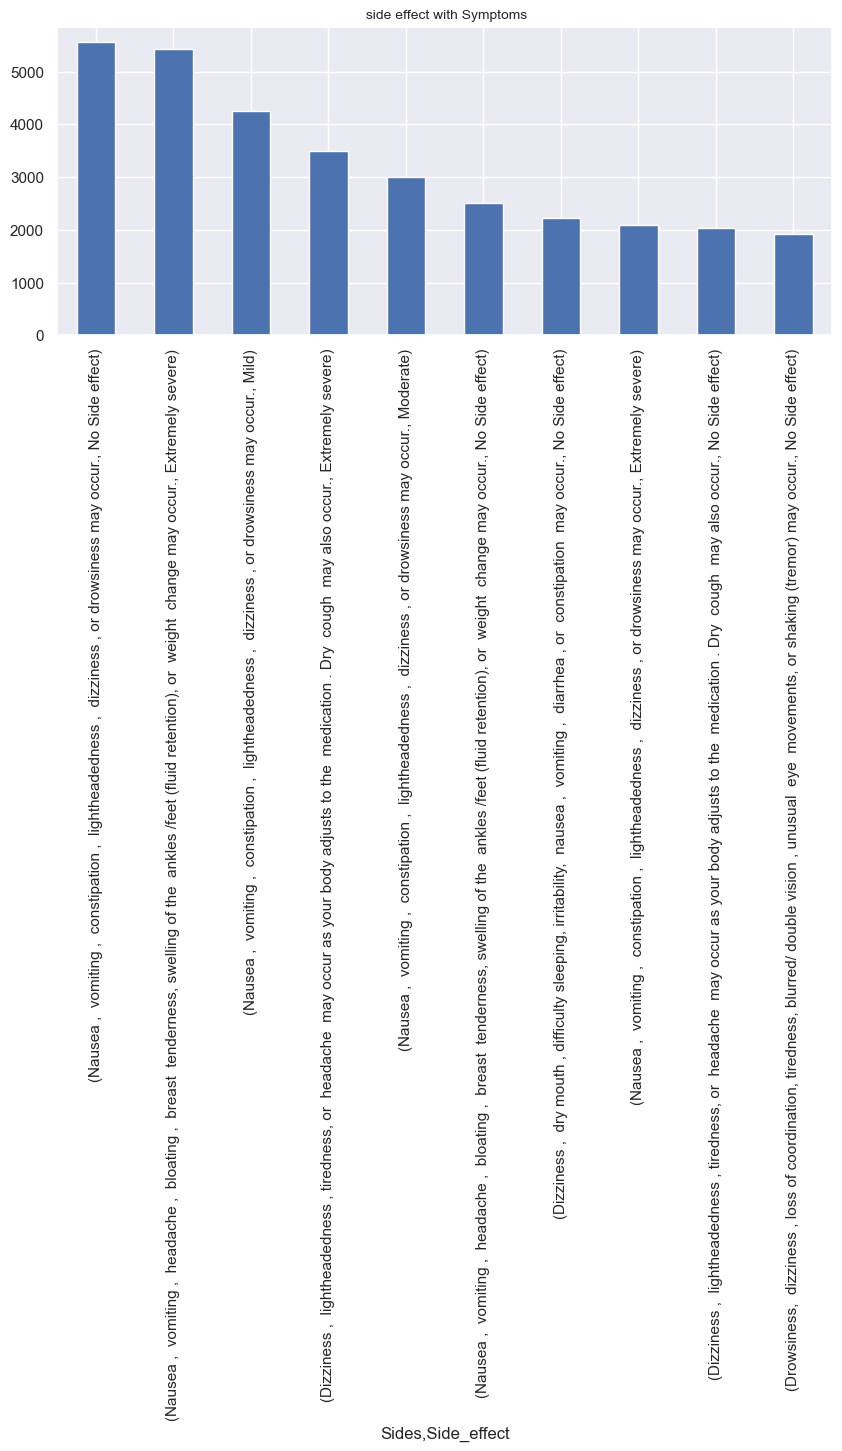

In [74]:
sides = data1.groupby('Sides')['Side_effect'].value_counts().nlargest(10).plot(kind='bar')

plt.title(" side effect with Symptoms", fontsize = 10)

Text(0.5, 1.0, 'Barchart of side effect with Satisfaction Rating')

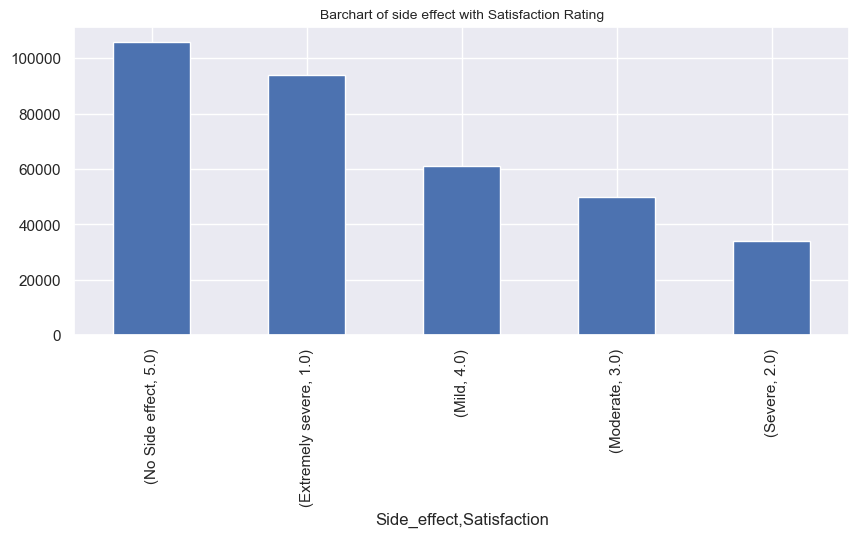

In [75]:
sideeffect = data1.groupby('Side_effect')['Satisfaction'].value_counts().nlargest(10).plot(kind='bar')

plt.title("Barchart of side effect with Satisfaction Rating", fontsize = 10)

Text(0.5, 0, 'Satisfaction')

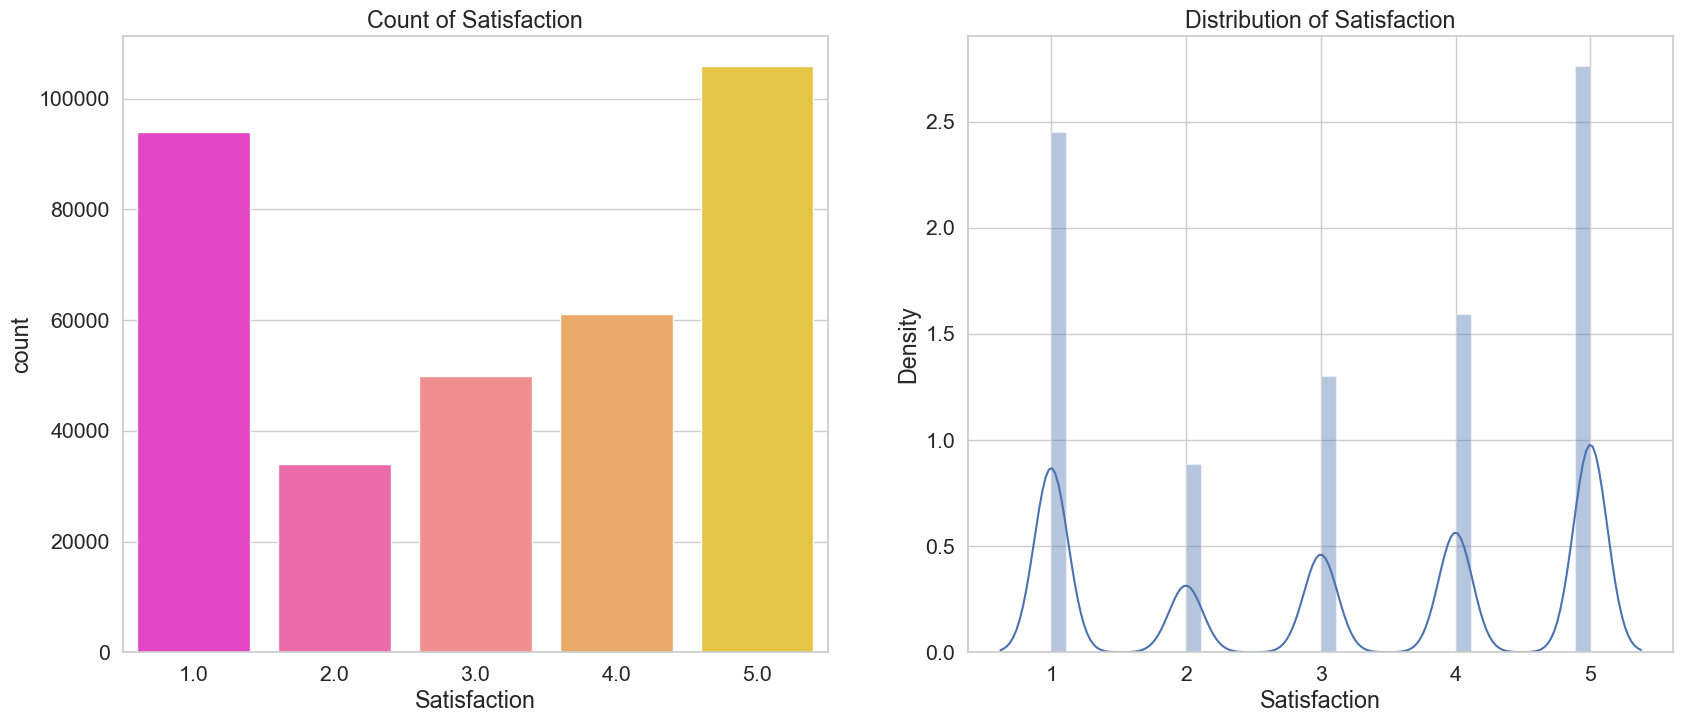

In [76]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1=sns.countplot(x=data1["Satisfaction"],palette = 'spring', ax=ax[0])
sns_2 = sns.distplot(data1['Satisfaction'], ax = ax[1])
sns_1.set_title('Count of Satisfaction')
sns_1.set_xlabel("Satisfaction")

sns_2.set_title('Distribution of Satisfaction')
sns_2.set_xlabel("Satisfaction")

Text(0.5, 0, 'Effectiveness')

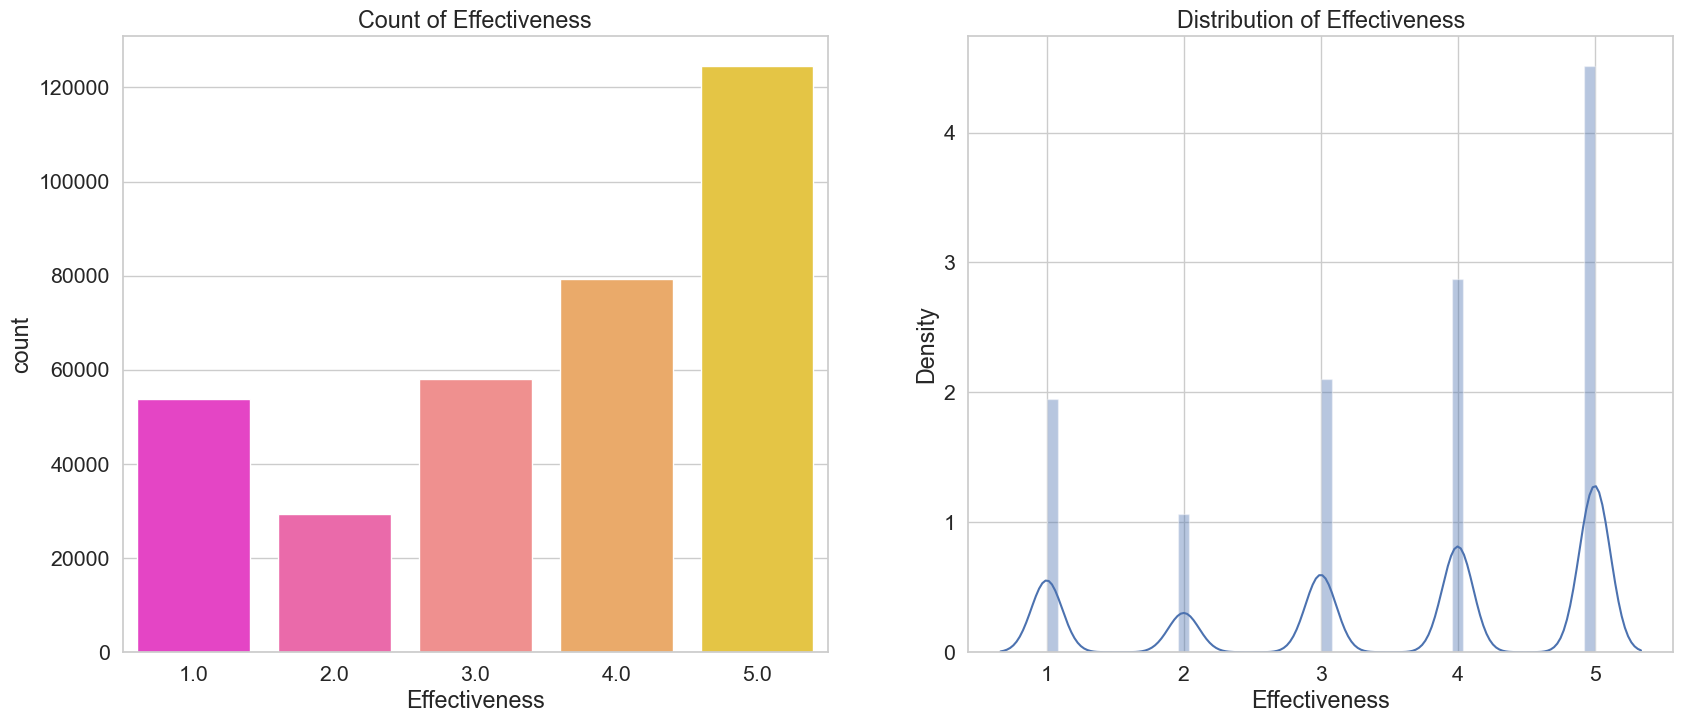

In [77]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(x=data1['Effectiveness'], palette = 'spring', ax = ax[0])
sns_2 = sns.distplot(data1['Effectiveness'], ax = ax[1])
sns_1.set_title('Count of Effectiveness')
sns_1.set_xlabel("Effectiveness")

sns_2.set_title('Distribution of Effectiveness')
sns_2.set_xlabel("Effectiveness")

Text(0.5, 0, 'EaseofUse')

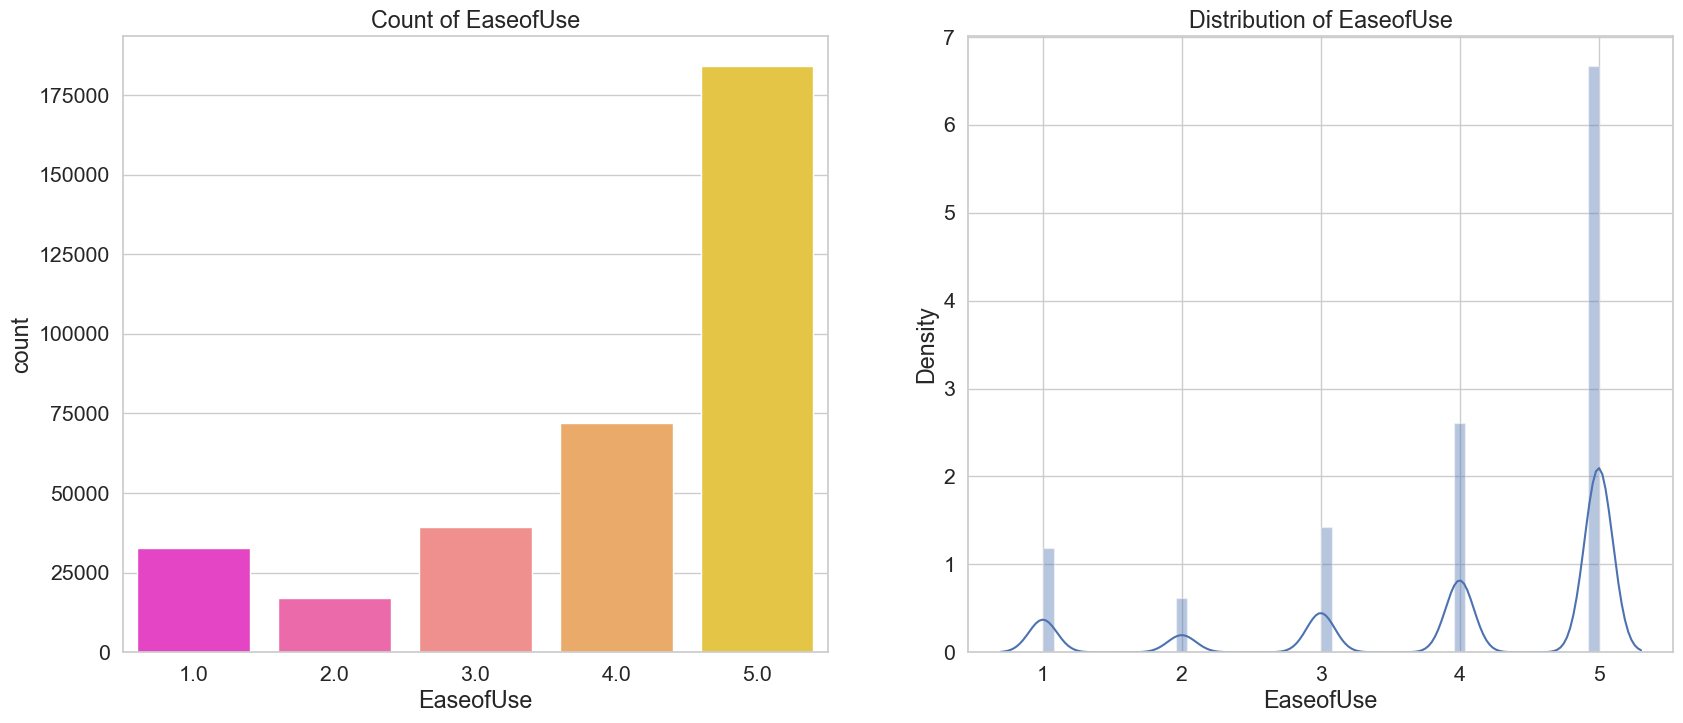

In [78]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(x=data1['EaseofUse'], palette = 'spring', ax = ax[0])
sns_2 = sns.distplot(data1['EaseofUse'], ax = ax[1])
sns_1.set_title('Count of EaseofUse')
sns_1.set_xlabel("EaseofUse")

sns_2.set_title('Distribution of EaseofUse')
sns_2.set_xlabel("EaseofUse")

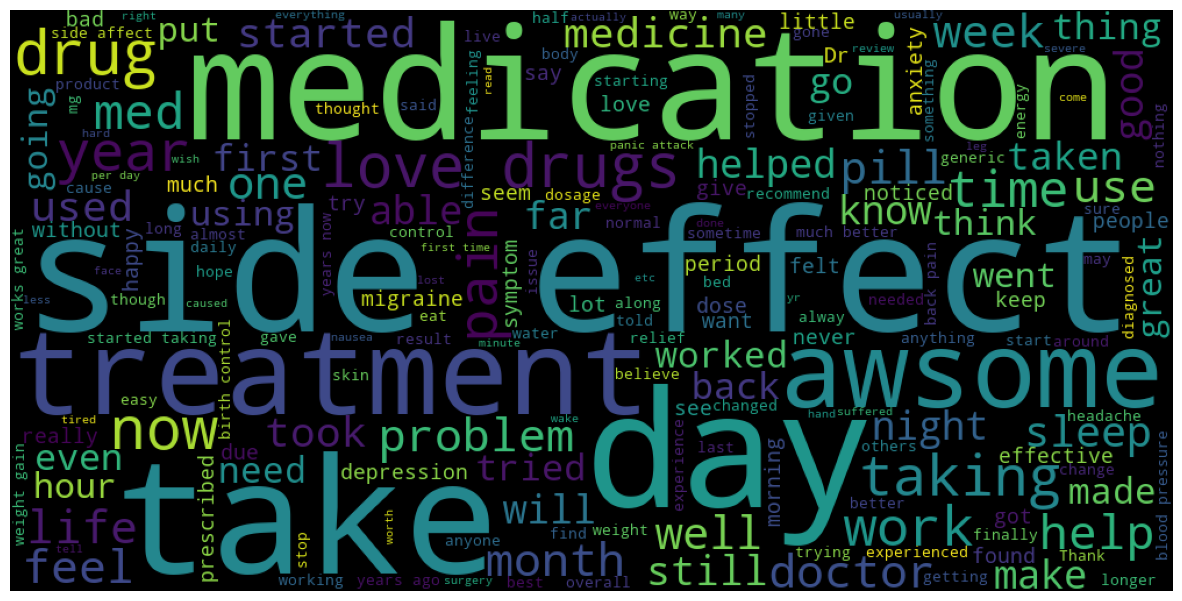

In [79]:
# Word cloud of the reviews with Satisfaction_rating equal to 5
review = data1.loc[data1.Satisfaction == 5, 'Reviews']
k = (' '.join(review))
wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

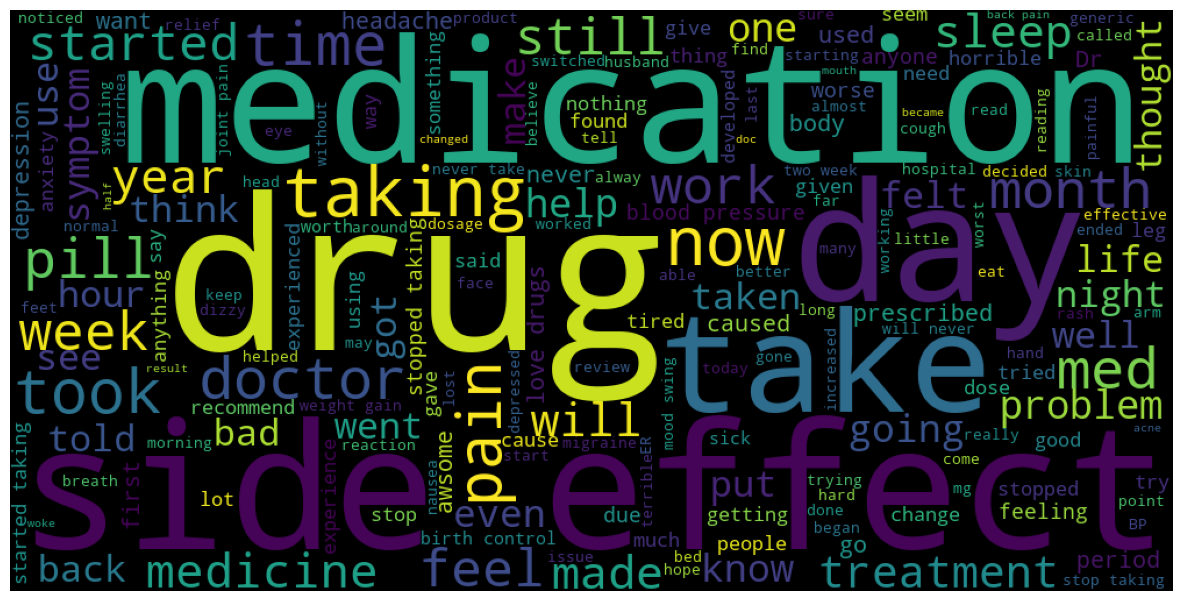

In [80]:
# Word cloud of the reviews with Satisfaction_rating equal to 1
review1 = data1.loc[data1.Satisfaction == 1, 'Reviews']
k = (' '.join(review1))
wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

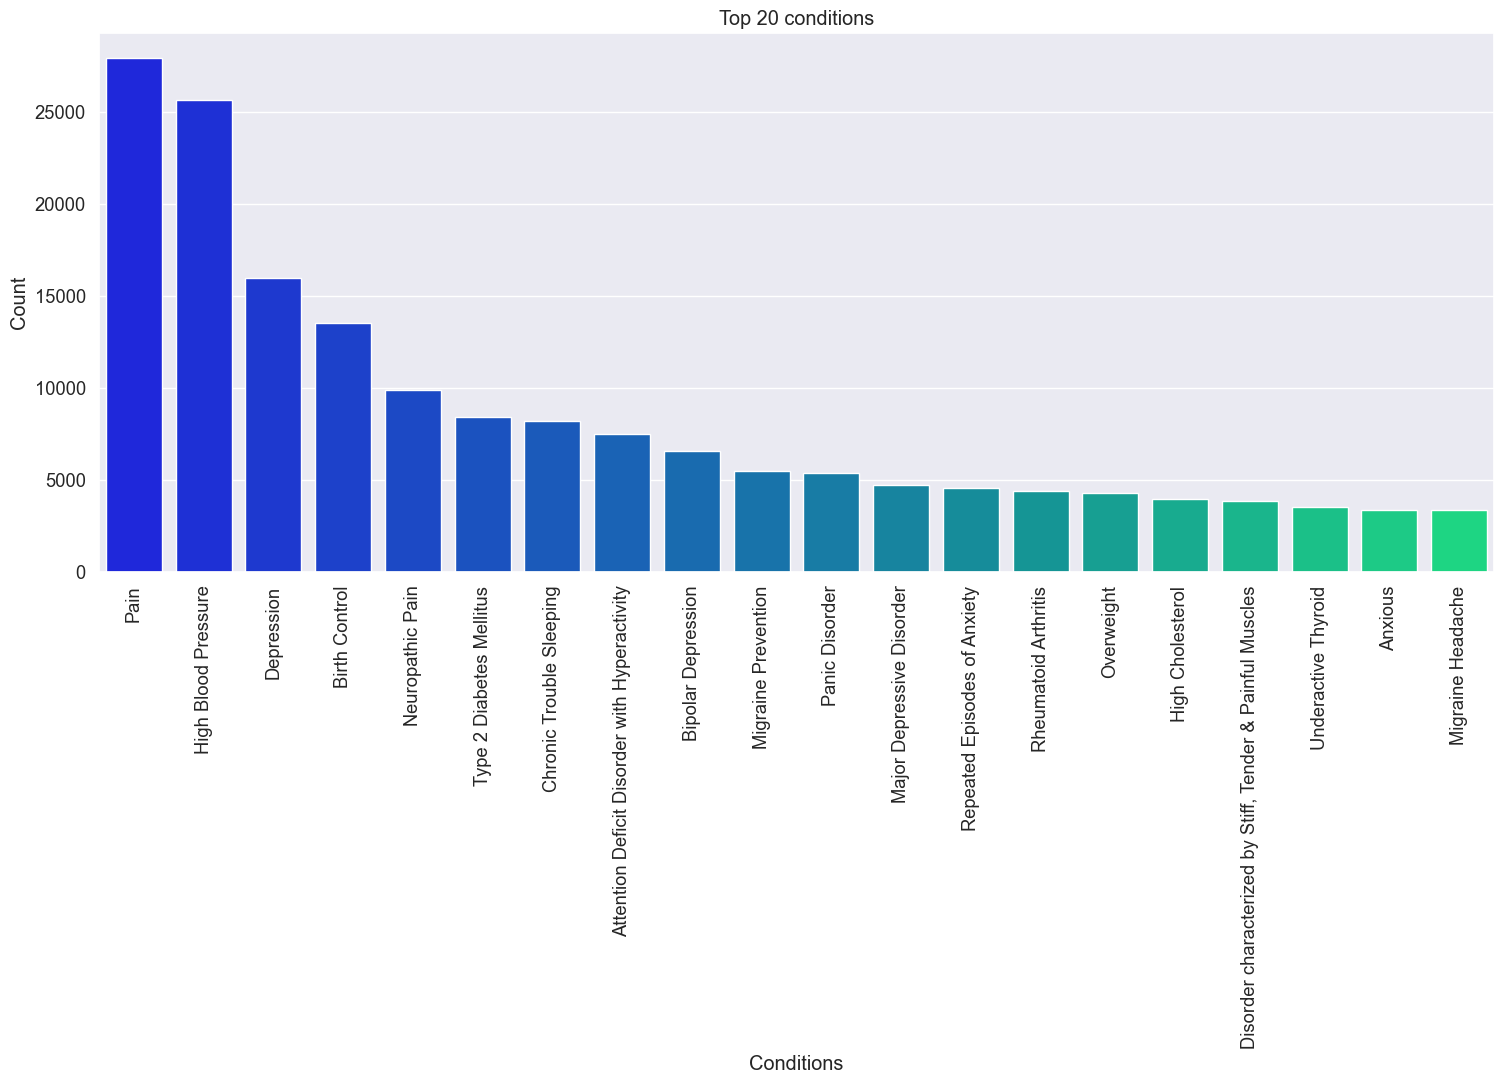

In [81]:
# This barplot show the top 20 conditions the people are suffering.
cond = dict(data1['Condition'].value_counts())
top_condition = list(cond.keys())[0:20]
values = list(cond.values())[0:20]
sns.set(style = 'darkgrid', font_scale = 1.2)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 20 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");
plt.setp(sns_.get_xticklabels(), rotation=90);

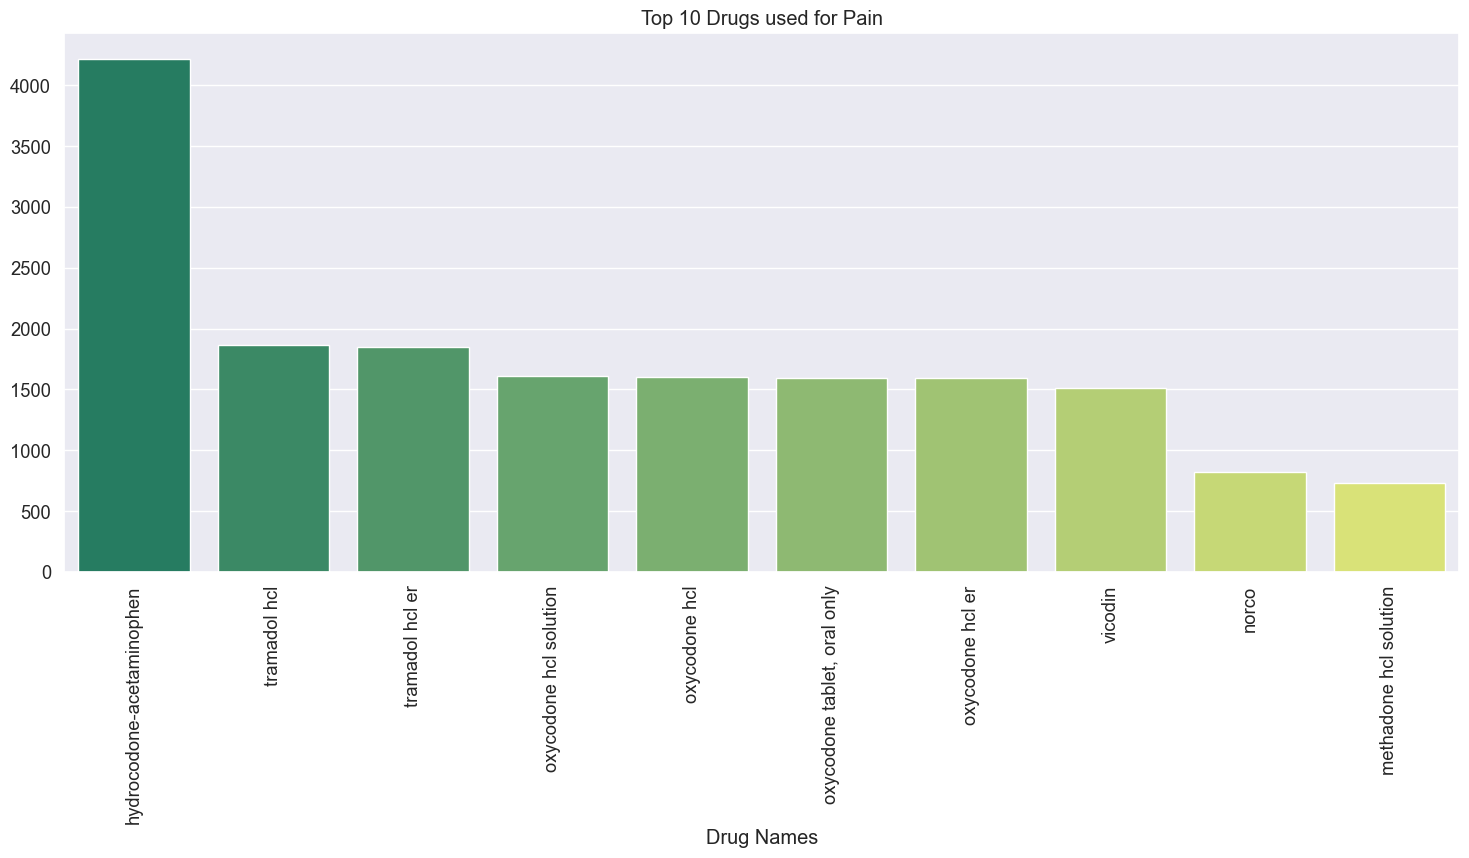

In [82]:
# Top 10 drugs which are used for the pain condition.
df = data1[data1['Condition'] == 'Pain']['Drug'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df.index, y = df.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Pain")
plt.setp(sns_.get_xticklabels(), rotation = 90);

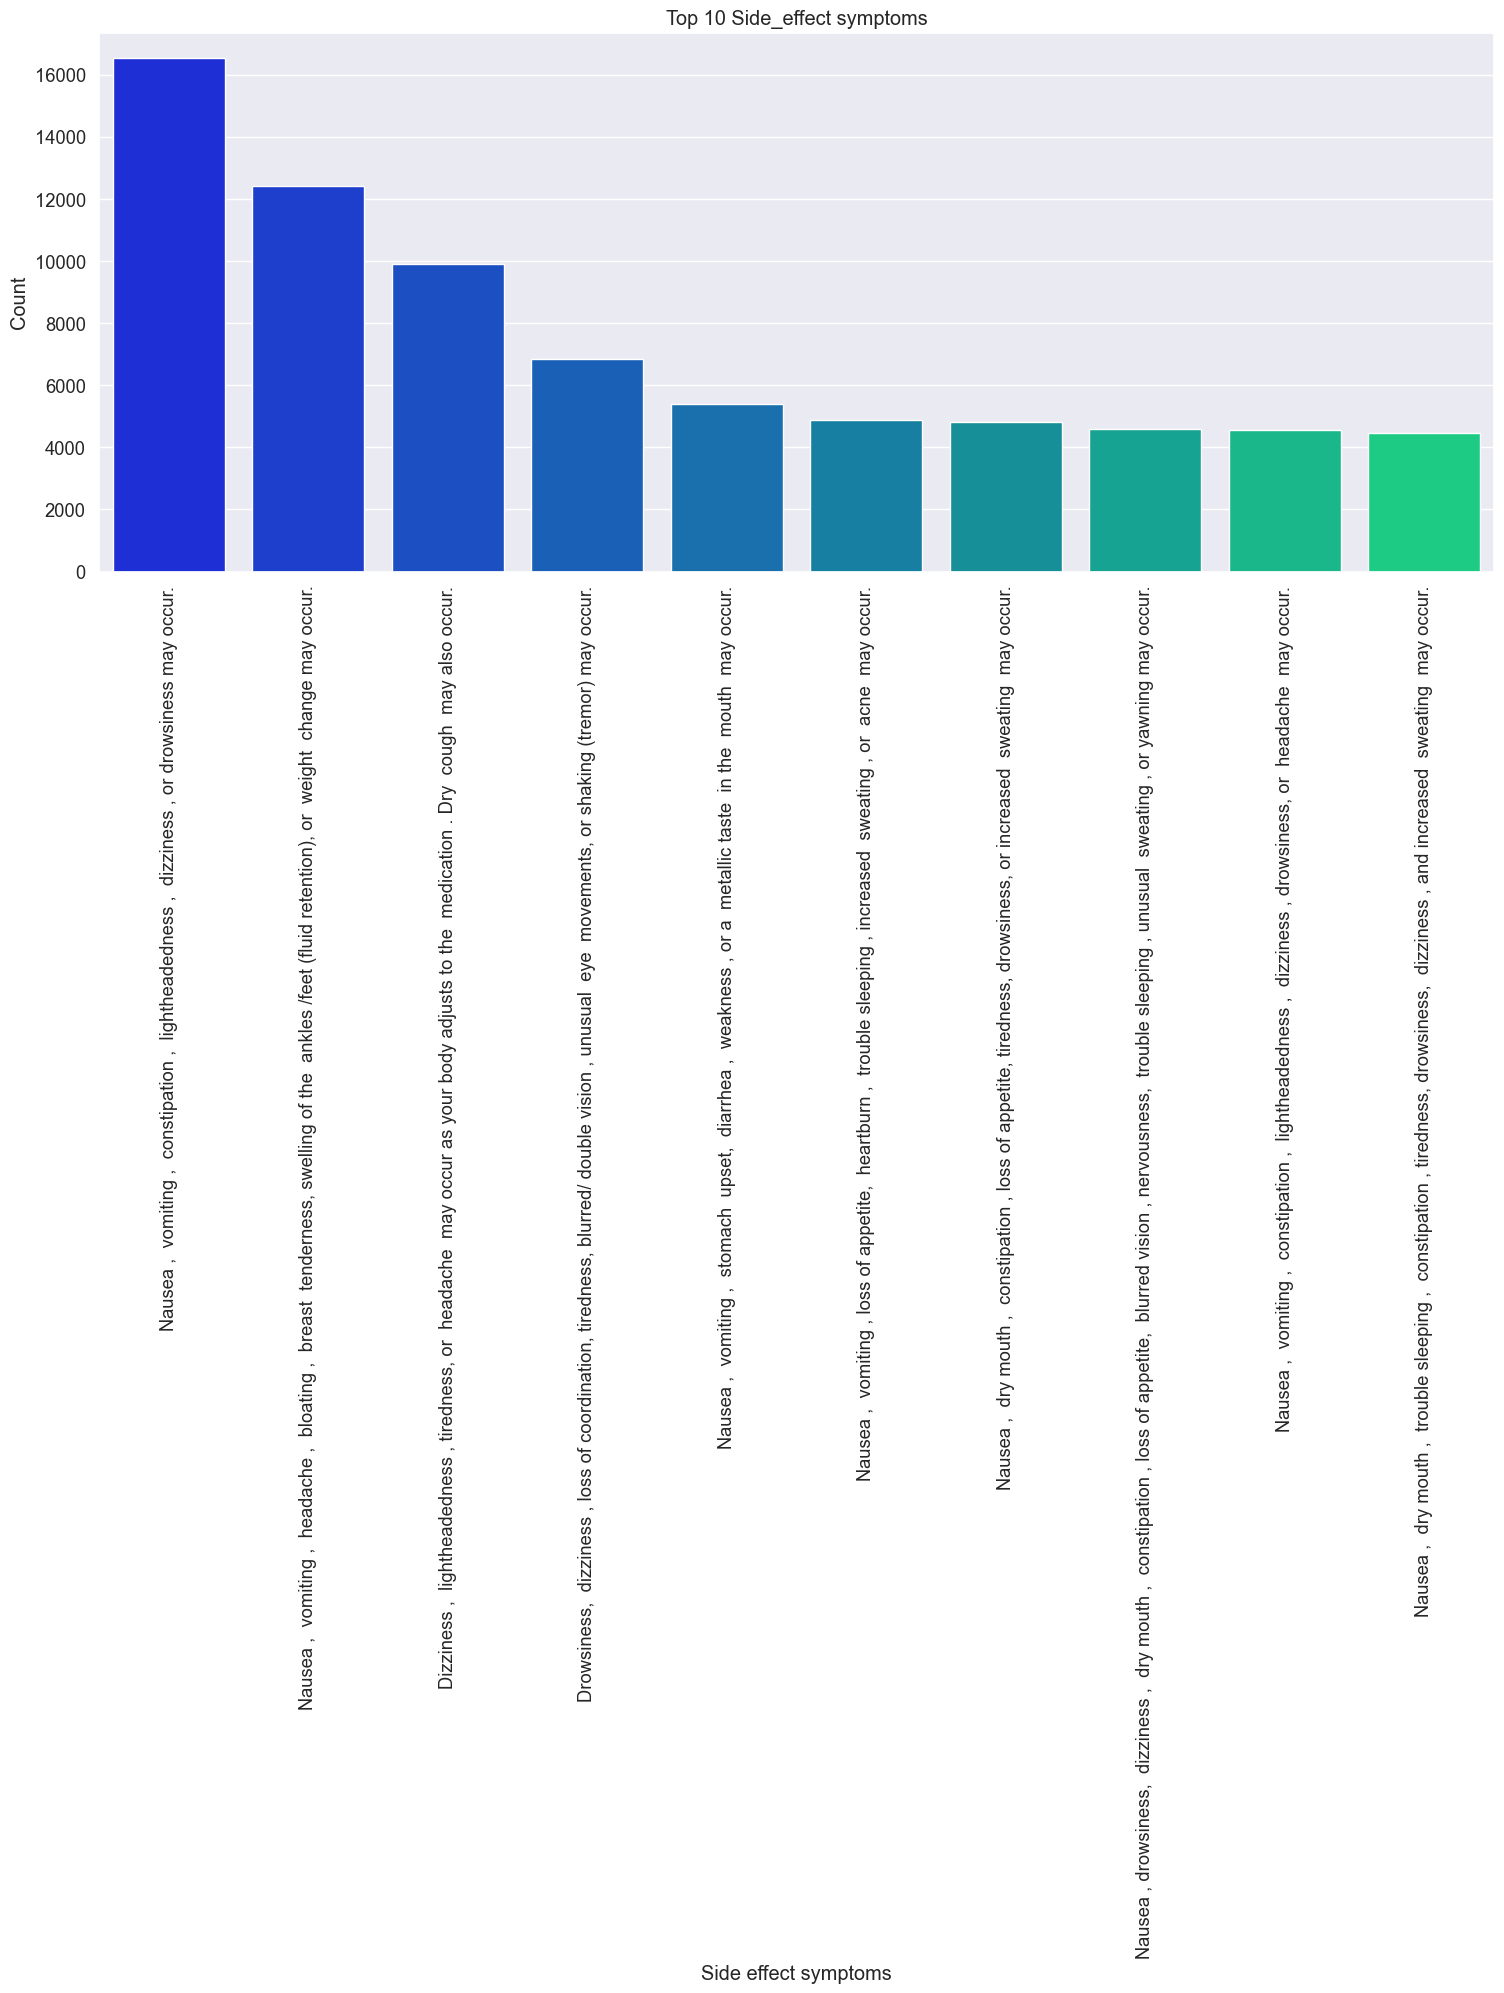

In [83]:
# This barplot show the top 10 side_effect symptoms
side = dict(data1['Sides'].value_counts())
top_Sides = list(side.keys())[0:10]
values = list(side.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.2)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_Sides, y = values, palette = 'winter')
sns_.set_title("Top 10 Side_effect symptoms")
sns_.set_xlabel("Side effect symptoms")
sns_.set_ylabel("Count");
plt.setp(sns_.get_xticklabels(), rotation=90);


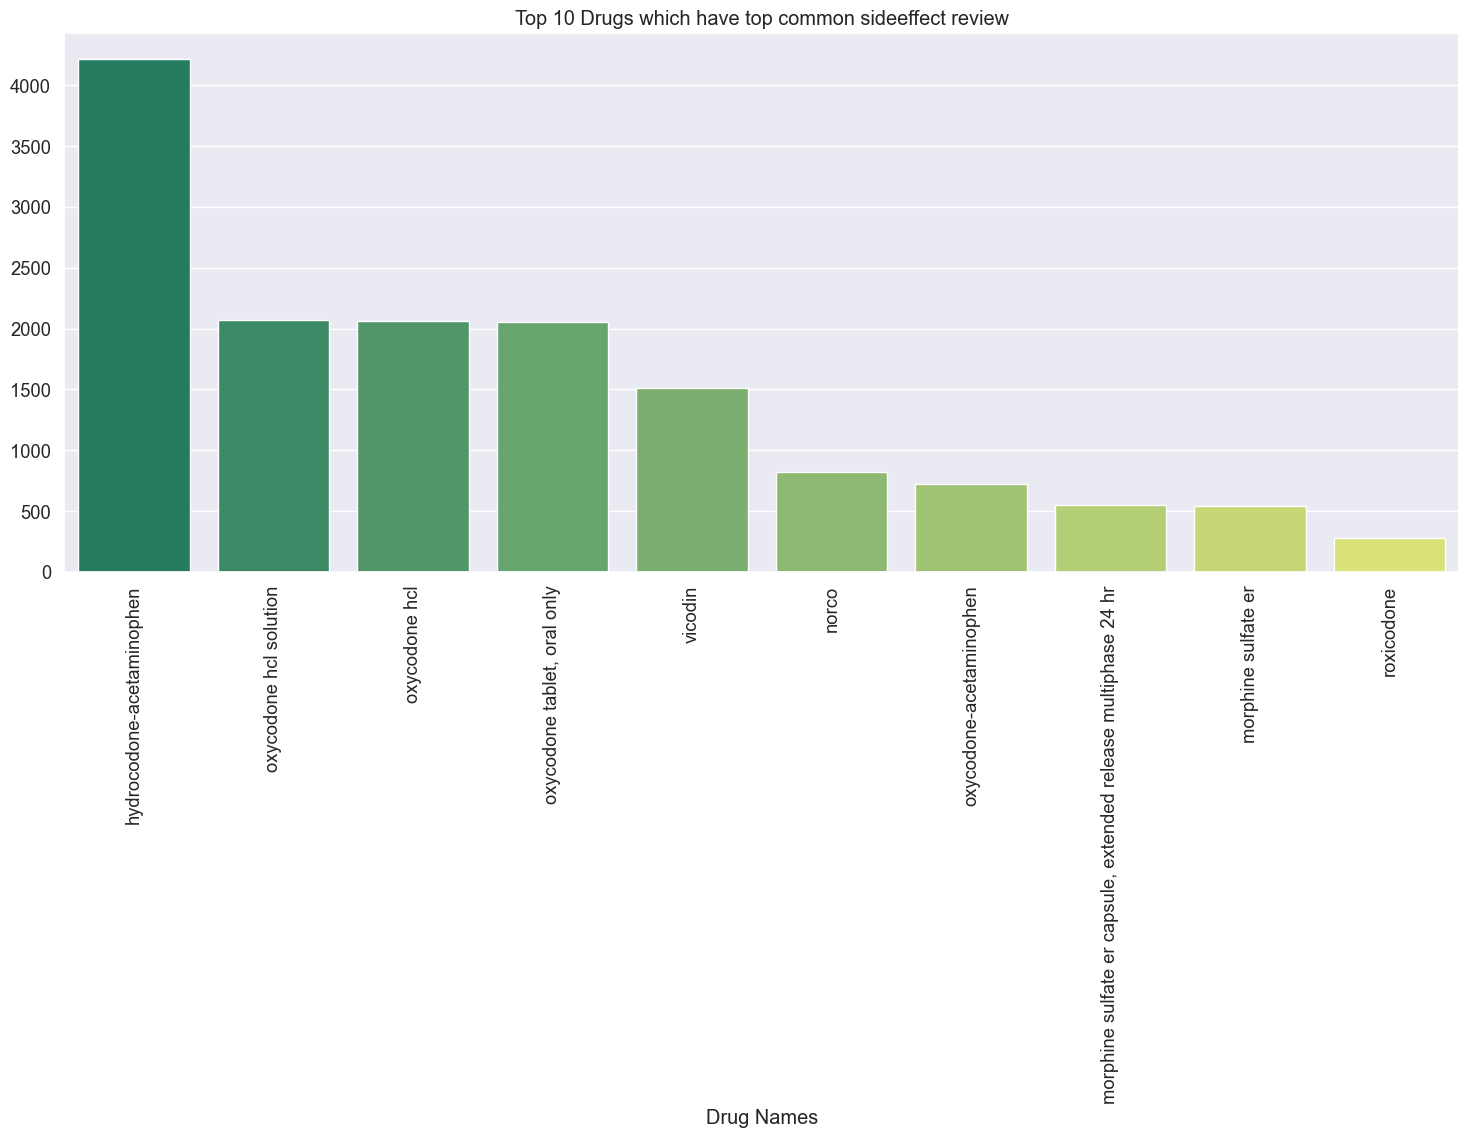

In [84]:
# Top 10 drugs which are responsible for top most side effect  
df1 = data1[data1['Sides'] == 'Nausea ,  vomiting ,  constipation ,  lightheadedness ,  dizziness , or drowsiness may occur.']['Drug'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs which have top common sideeffect review")
plt.setp(sns_.get_xticklabels(), rotation = 90);

Text mining on Side-effect symptoms

In [85]:
data1.Sides.sample(5)

362065    Nausea ,  headache ,  vomiting , drowsiness, g...
179116    Nausea ,  vomiting ,  headache ,  bloating ,  ...
67507     Mild  itching , redness, burning, and stinging...
94271     Nausea ,  vomiting ,  stomach  upset,  diarrhe...
279037    Trouble sleeping , nervousness,  nausea ,  sto...
Name: Sides, dtype: object

Cleaning the Sides column

In [86]:
data1['Sides'].dtype

dtype('O')

In [87]:
if data1['Sides'].dtype.kind == "O":
    data1['Sides'] = data1['Sides'].str.strip()

In [88]:
data1['Sides']= data1['Sides'].astype(str)

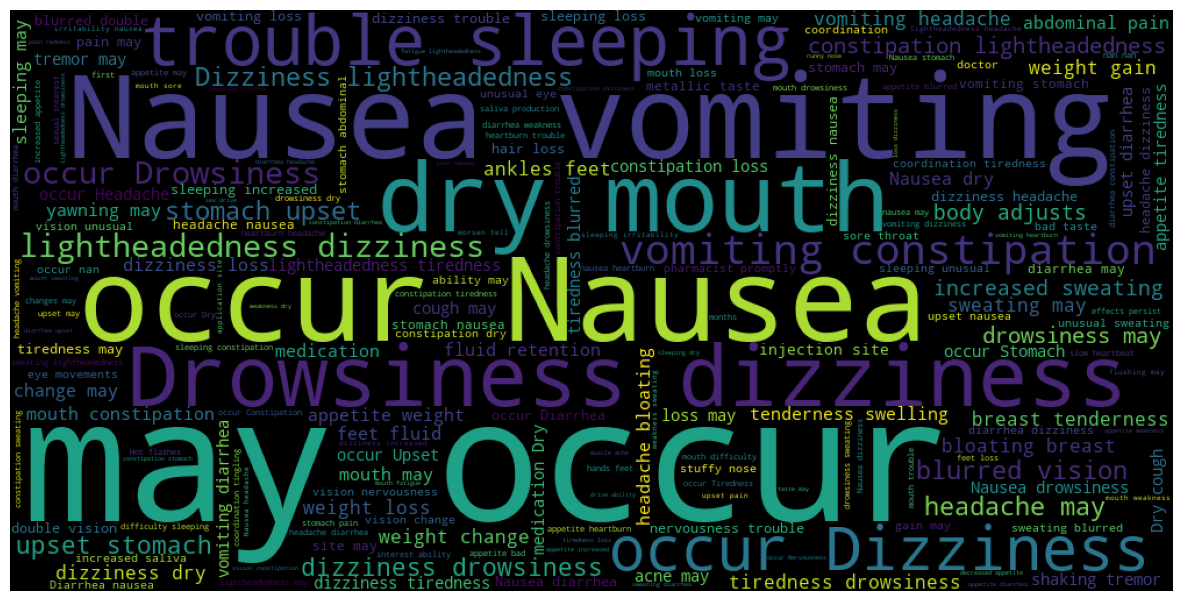

In [89]:
# Word cloud of the Symptoms
wc_rate_sides = data1['Sides']
k = (' '.join(wc_rate_sides))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

In [90]:
#To map Drug and Symptoms columns
drug_symptoms = data1.set_index('Drug')['Sides'].to_dict()
drug_symptoms

{'25dph-7.5peh': 'Drowsiness,  dizziness ,  dry mouth /nose/throat,  headache ,  upset stomach ,  constipation , or  trouble sleeping  may occur.',
 'wymzya fe': 'Nausea ,  vomiting ,  headache ,  bloating ,  breast  tenderness, swelling of the  ankles /feet (fluid retention), or  weight  change may occur.',
 '12 hour nasal relief spray, non-aerosol': 'Temporary burning, stinging, dryness in the nose,  runny nose , and  sneezing  may occur.',
 'lyza': 'Nausea ,  vomiting ,  headache ,  bloating ,  breast  tenderness, or  weight  gain may occur.',
 'lysteda': 'Nausea ,  vomiting ,  diarrhea , and  muscle pain  may occur.',
 'pyrithione zinc shampoo': 'nan',
 'lynparza tablet': 'Nausea ,  vomiting , loss of appetite,  diarrhea ,  headache ,  dizziness , change in the way food tastes, or tiredness may occur.',
 'lynparza': 'Nausea ,  vomiting , loss of appetite,  diarrhea ,  constipation , bad taste in your  mouth ,  dizziness , or  joint /back/ muscle pain  may occur.',
 'lyrica': 'Drows

In [91]:
#pickle the mapped dictionary
symptoms_pkl=open('symptoms.pkl','wb')
pickle.dump(drug_symptoms,symptoms_pkl)
symptoms_pkl.close()

###### Text Mining on Reviews

Let us define a function to clean the text in the review column to generate meaningfull output. The plan is to rank the reviews as either positive or negative.The algorithm will get trained on satisfaction and reviews, which means, it will identify which reviews or specifically word consitutes positive review ( satisfaction > 3) and which one consitute negative reviews (satisfaction < 3). Then, the generated model will be used to generate review rank ( 1 for positve and 0 for negative) for us in our dataset. Kindly note, the review rank for entries where satisfaction > 3 is 1 and for satisfaction < 3 is 0. The entries with satisfaction == 3 will be fed to the model to generate review rank values. 

In [92]:
data1.Reviews.sample(5)

264354    Did not Work. My cough got worse and i couldnt...
375133    Took this medication for about one year and wh...
78004     I Believe It's A Joke Or Slap In The Face. Whe...
227887    Although this medicine seemed to help my sinus...
123725    have infection in nose, weak all over,very wea...
Name: Reviews, dtype: object

Cleaning the Reviews column

In [93]:
data1['Reviews'].dtype

dtype('O')

In [94]:
if data1['Reviews'].dtype.kind == "O":
    data1['Reviews'] = data1['Reviews'].str.strip()

In [95]:
data1['Reviews']= data1['Reviews'].astype(str)

In [96]:
import en_core_web_sm
from spacy.lang.en.examples import sentences
import nltk  
#nltk.download()

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
STOPWORDS = set(sklearn_stop_words).union(set(stopwords.words("english")))

def clean_review(text, STOPWORDS=STOPWORDS, nlp=nlp):
    """Cleans up text"""
    def rep_emo(text, placeholder_pos=' happyemotion ', placeholder_neg=' sademotion '):
        """Replace emotions"""
        emotions_pos = [":)", ":-)", ":p", ":-p", ":P", ":-P", ":D",":-D", ":]", ":-]", ";)", ";-)",
                         ";p", ";-p", ";P", ";-P", ";D", ";-D", ";]", ";-]", "=)", "=-)", "<3"]
        emotions_neg = [":o", ":-o", ":O", ":-O", ":(", ":-(", ":c", ":-c", ":C", ":-C", ":[", ":-[",
                         ":/", ":-/", ":\\", ":-\\", ":n", ":-n", ":u", ":-u", "=(", "=-(", ":$", ":-$"]

        for e in emotions_pos:
            text = text.replace(e, placeholder_pos)

        for e in emotions_neg:
            text = text.replace(e, placeholder_neg)   
        return text

    def rep_punct(text):
        """Replace all punctuation with space"""
        for c in string.punctuation:
            text = text.replace(c, " ")
        return text

    def rem_stop_num(text):
        """Remove stop words and anything starting with number"""
        return " ".join(word for word in text.split() if word not in STOPWORDS and not word[0].isdigit())

    def lemmatize(text):
        """Return lemmas of tokens in text"""
        return " ".join(tok.lemma_.lower().strip() for tok in nlp(text) if tok.lemma_ != "-PRON-")  

    return lemmatize(rem_stop_num(rep_punct(rep_emo(text))))

data_review = data1[["Satisfaction", "Reviews"]]
data_review["Reviews"] = data_review["Reviews"].apply(clean_review)

# remove any rows with new empty strings following the clean-up
data_review["Reviews"].replace("", np.nan, inplace=True)
data_review.dropna(inplace=True)
# adding indexes as "index" column for later use to recreate same splits 
data_review.reset_index(inplace=True)

Review column is cleaned. A new column satisfaction_review is generated which will help in identifiying postive and negative reviews for algorithm where 0 is negative, 2 is positive and 1 is neutral for satisfaction < 3, > 3 and ==3 respectively. We will omit the neutral reviews

In [97]:
def relabel(x):
    return 0 if x < 3 else 1 if x == 3 else 2

data_review["Satisfaction_review"] = data_review["Satisfaction"].apply(relabel)

In [98]:
data_review

index  Satisfaction  \
0            0           5.0   
1            1           5.0   
2            6           2.0   
3            7           5.0   
4            8           2.0   
...        ...           ...   
344799  399994           1.0   
344800  399995           1.0   
344801  399997           5.0   
344802  399998           4.0   
344803  399999           1.0   

                                                  Reviews  Satisfaction_review  
0       i retire physician med i try allergy seasonal ...                    2  
1           clear right throat hurt go away take medicine                    2  
2       haven get pregnant job i switch brand generic ...                    0  
3       i year age prevent ovarian cyst i burst now st...                    2  
4                            treatment awsome i love drug                    0  
...                                                   ...                  ...  
344799  it generally take pill i begin feel pain start...                    0  
344800  i last week work pain nausea headache severe d...                    0  
344801  my doctor presribe i develop allergic reaction...                    2  
344802  i lexapro past year i regain life use drug i s...                    2  
344803  i joint pain take knee my oncologist say proba...                    0  

[344804 rows x 4 columns]

In [99]:
data_review.Satisfaction_review

0         2
1         2
2         0
3         2
4         0
         ..
344799    0
344800    0
344801    2
344802    2
344803    0
Name: Satisfaction_review, Length: 344804, dtype: int64

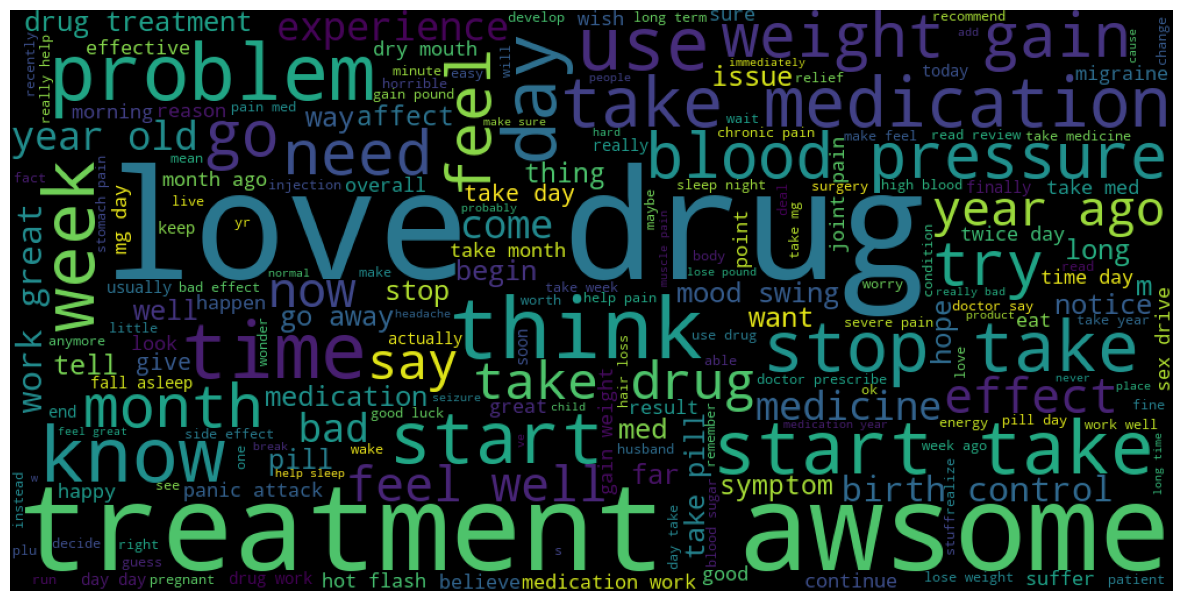

In [100]:
# Word cloud of the Clean reviews
wc_rate_review = data_review['Reviews']
k = (' '.join(wc_rate_review))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

###### Generating Text processing Model

In [101]:
train_set, test_set = train_test_split(data_review, test_size=0.20, random_state=42, stratify = data_review["Satisfaction_review"])
train_index = train_set.index
test_index = test_set.index
print(train_set.shape)
print(test_set.shape)

(275843, 4)
(68961, 4)


In [102]:
train_set = train_set[train_set["Satisfaction_review"] != 1]
test_set = test_set[test_set["Satisfaction_review"] != 1]
print(train_set.shape)
print(test_set.shape)

(235975, 4)
(58994, 4)


In [103]:
#vectorizer used for feature extraction in text classification(converting words into numbers)
from tmtoolkit.bow.bow_stats import tfidf

vectorizer = TfidfVectorizer(max_features=2500, min_df=10, max_df=0.8)
X_train = vectorizer.fit_transform(train_set["Reviews"]).toarray()
X_test = vectorizer.transform(test_set["Reviews"]).toarray()
y_train = train_set["Satisfaction_review"].values
y_test = test_set["Satisfaction_review"].values

model = RandomForestClassifier(min_samples_split=6, random_state=42)
model.fit(X_train, y_train)

acc_train = accuracy_score(y_train, model.predict(X_train))
print(f"\nAccuracy in train set: {acc_train:.2}")
predictions = model.predict(X_test)
acc_test = accuracy_score(y_test, predictions)
print(f"\nAccuracy in test  set: {acc_test:.2}\n")
print(classification_report(y_test, predictions))


Accuracy in train set: 0.97

Accuracy in test  set: 0.85

              precision    recall  f1-score   support

           0       0.87      0.78      0.82     25597
           2       0.85      0.91      0.88     33397

    accuracy                           0.85     58994
   macro avg       0.86      0.85      0.85     58994
weighted avg       0.85      0.85      0.85     58994



 A drug named Cymbalta with DrugId 91491 is selected in building a classification model to determine the side effects

In [104]:
data2 = data1[data1.DrugId == 91491]
data2

Name      Race    Age  \
314212      Archie     White   7-12   
314216  Georgianne     White  45-54   
314223        Josh  Hispanic  45-54   
314235        Suzi     White  35-44   
314246     Margert     Black  55-64   
...            ...       ...    ...   
399417      Kelsie     Black  45-54   
399545       Erich  Hispanic  25-34   
399630     Nicolas  Hispanic  35-44   
399791      Debbra     White  65-74   
399807      Hayden     White  35-44   

                                                Condition       Date  \
314212                          Major Depressive Disorder 2020-02-29   
314216                       Repeated Episodes of Anxiety 2020-01-13   
314223             Anxiousness associated with Depression 2020-01-04   
314235             Anxiousness associated with Depression 2019-12-06   
314246                        Chronic Muscle or Bone Pain 2019-11-20   
...                                                   ...        ...   
399417  Disorder characterized by Stiff, Tender & Pain... 2013-08-27   
399545                          Major Depressive Disorder 2010-05-27   
399630                          Major Depressive Disorder 2011-03-17   
399791                          Major Depressive Disorder 2014-06-14   
399807                        Chronic Muscle or Bone Pain 2012-01-03   

            Drug   DrugId  EaseofUse  Effectiveness  \
314212  cymbalta  91491.0        5.0            5.0   
314216  cymbalta  91491.0        3.0            1.0   
314223  cymbalta  91491.0        5.0            5.0   
314235  cymbalta  91491.0        3.0            3.0   
314246  cymbalta  91491.0        2.0            2.0   
...          ...      ...        ...            ...   
399417  cymbalta  91491.0        5.0            1.0   
399545  cymbalta  91491.0        5.0            5.0   
399630  cymbalta  91491.0        5.0            5.0   
399791  cymbalta  91491.0        4.0            4.0   
399807  cymbalta  91491.0        4.0            2.0   

                                                  Reviews  Satisfaction  \
314212  No Script or health Insurance needed to place ...           5.0   
314216  I was prescribed Cymbalta for anxiety and star...           1.0   
314223  Switched from Effexor to this medicine after 1...           5.0   
314235  Bipolar I with a neck fusion. Pdoc prescribed ...           2.0   
314246  I have depression, anxiety, Fibro, severe musc...           2.0   
...                                                   ...           ...   
399417  have been taking for less than 2 weeks. @30mg ...           1.0   
399545  Been on this med for 4 years and it has really...           4.0   
399630  I began taking this becuase of major depressio...           5.0   
399791           this treatment is awsome.  I love drugs.           4.0   
399807  A while back I wrote a great review......Have ...           2.0   

        Gender                                              Sides  \
314212  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314216    Male  Nausea ,  dry mouth ,  constipation , loss of ...   
314223  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314235  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314246  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
...        ...                                                ...   
399417  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
399545    Male  Nausea ,  dry mouth ,  constipation , loss of ...   
399630  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
399791  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
399807  Female  Nausea ,  dry mouth ,  constipation , loss of ...   

        UsefulCount       Side_effect  Year  Month day_of_the_week  
314212    12.000000    No Side effect  2020      2        Saturday  
314216     0.000000  Extremely severe  2020      1          Monday  
314223     0.000000    No Side effect  2020      1        Saturday  
314235     0.

In [105]:
data2.shape

(4548, 18)

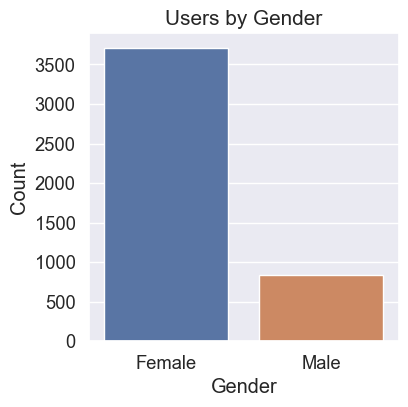

In [106]:
plt.figure(figsize = (4,4))
s=sns.countplot(x='Gender', data=data2)
plt.title('Users by Gender', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Count') 
plt.show()

Female users are more for this drug

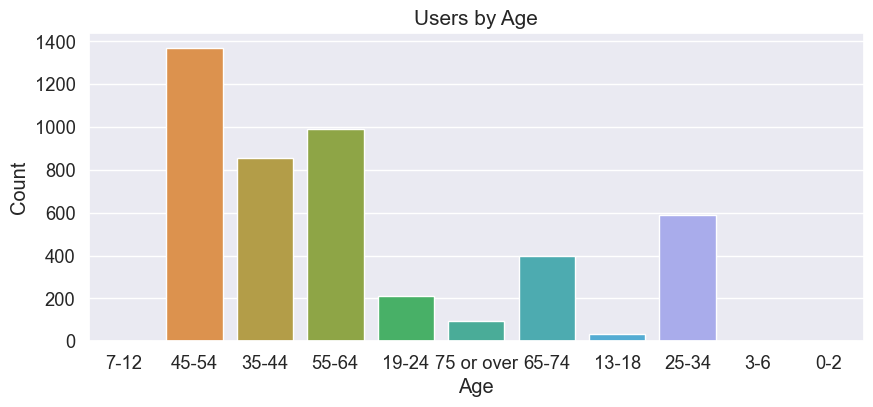

In [107]:
plt.figure(figsize = (10,4))
s=sns.countplot(x='Age', data=data2)
plt.title('Users by Age', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Count') 
plt.show()

45-54 age group uses this drug more

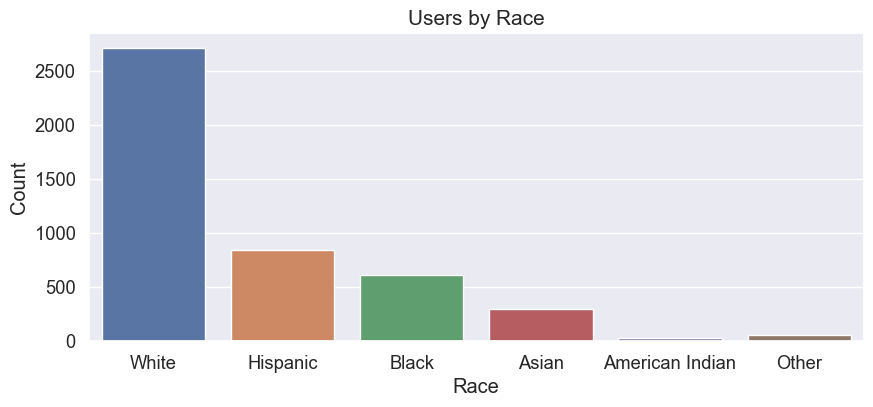

In [108]:
plt.figure(figsize = (10,4))
s=sns.countplot(x='Race', data=data2)
plt.title('Users by Race', fontsize=15)
plt.xlabel('Race')
plt.ylabel('Count') 
plt.show()

White people are using more than any other race

Text(0.5, 1.0, 'Users by Race and Gender')

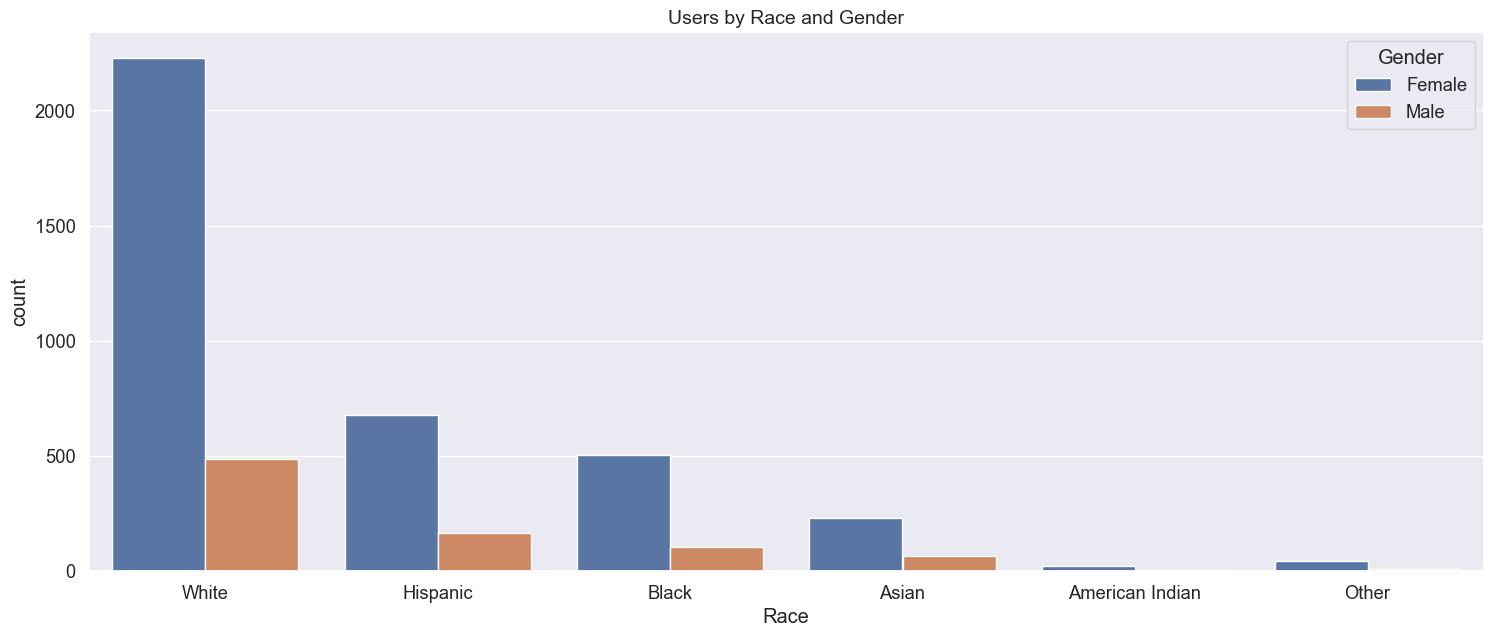

In [109]:
sns.countplot(x='Race',hue='Gender',data=data2)
plt.title("Users by Race and Gender", fontsize = 14)

White females are using the drug more

Text(0.5, 1.0, 'Users by Age and Gender')

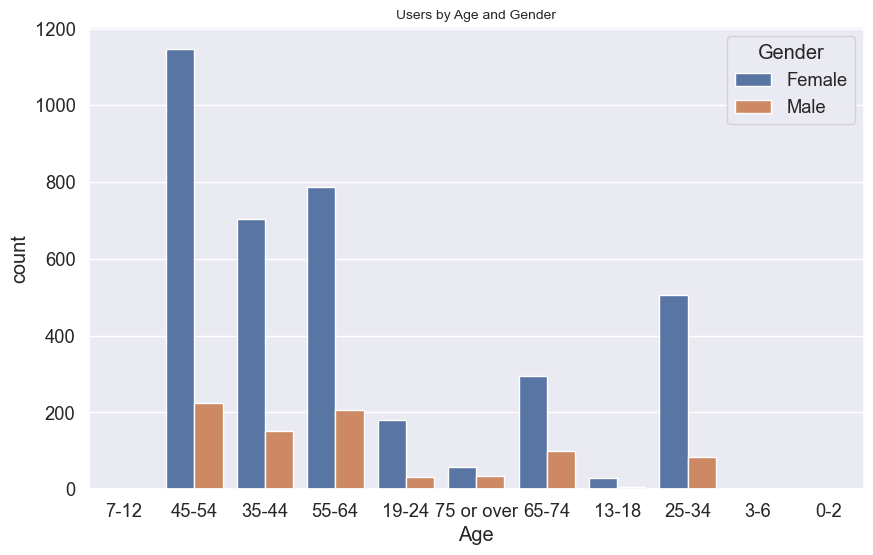

In [110]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Gender',data=data2)
plt.title("Users by Age and Gender", fontsize = 10)

45-54 aged females using the drug more

Text(0, 0.5, 'Count')

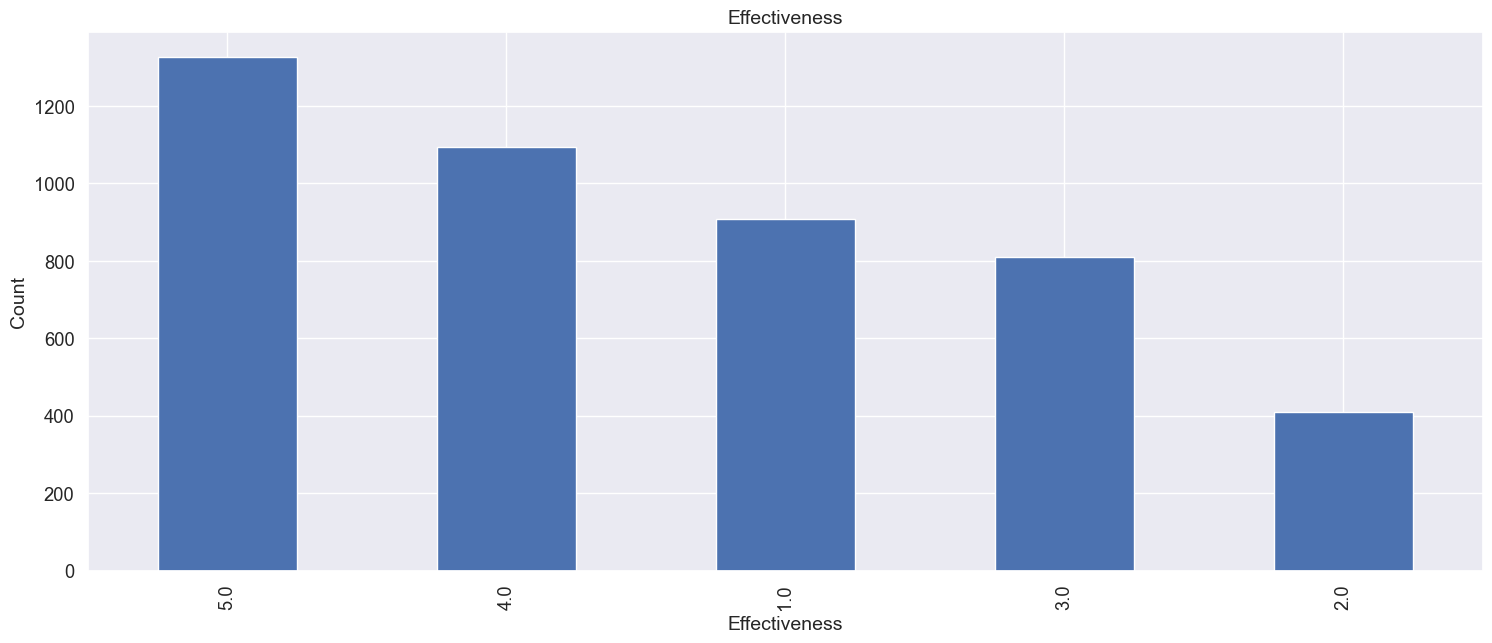

In [111]:
data2['Effectiveness'].value_counts().plot(kind='bar')
plt.title("Effectiveness", fontsize = 14)
plt.xlabel("Effectiveness", fontsize = 14)
plt.ylabel("Count", fontsize = 14)

<Figure size 1000x800 with 0 Axes>

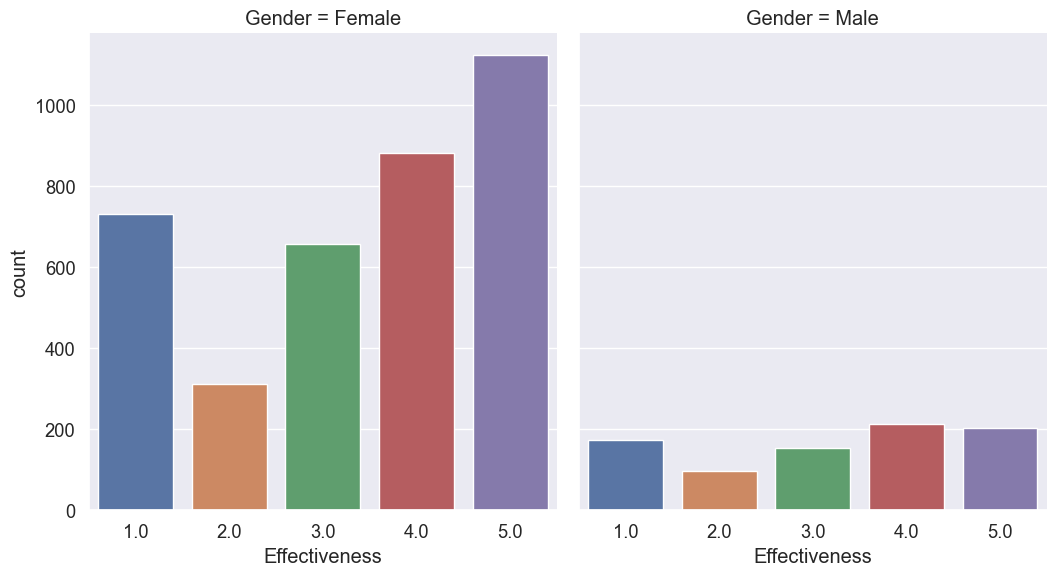

In [112]:
plt.figure(figsize=(10,8))
g = sns.catplot(x="Effectiveness",col="Gender",
                data=data2, kind="count",
                height=6,aspect =.9);

Both the users have given a mixed response

<Axes: xlabel='Effectiveness', ylabel='count'>

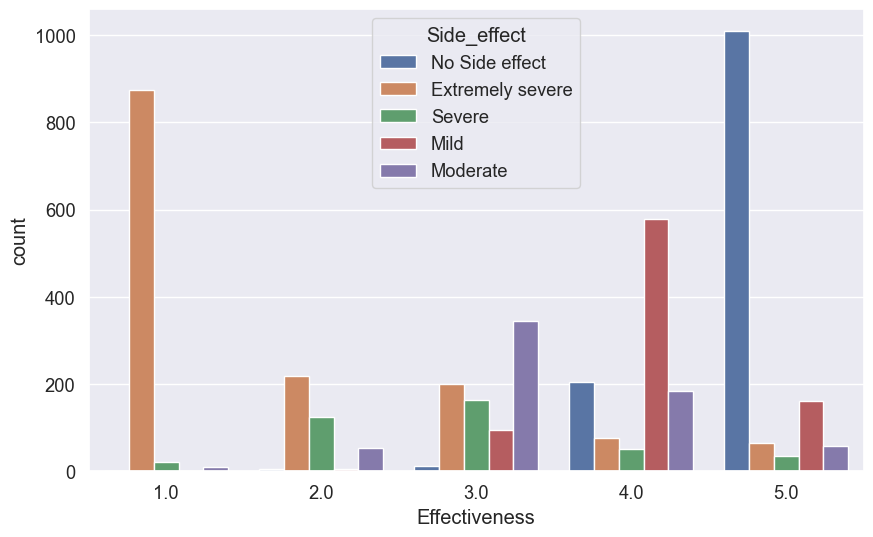

In [113]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Effectiveness',hue='Side_effect',data=data2)

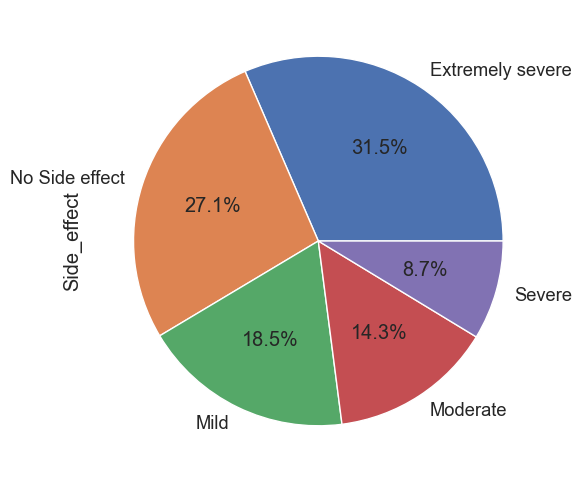

In [114]:
plt.figure(figsize=(6,6))
data2['Side_effect'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

<Axes: xlabel='Age', ylabel='count'>

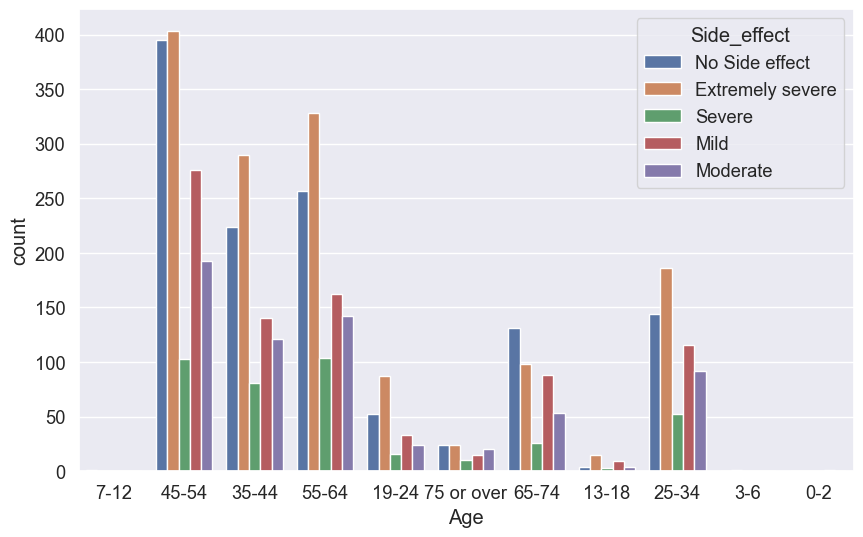

In [115]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Side_effect',data=data2)

45-54 age group has opinionated that they had extreme side effects

<Axes: xlabel='Gender', ylabel='count'>

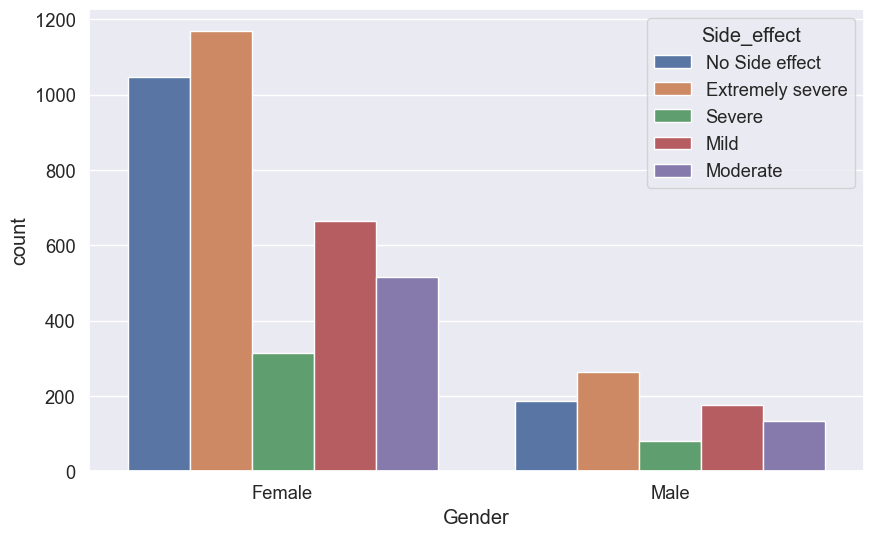

In [116]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender',hue='Side_effect',data=data2)

Female users have reported more extreme side effects

<Axes: xlabel='Race', ylabel='count'>

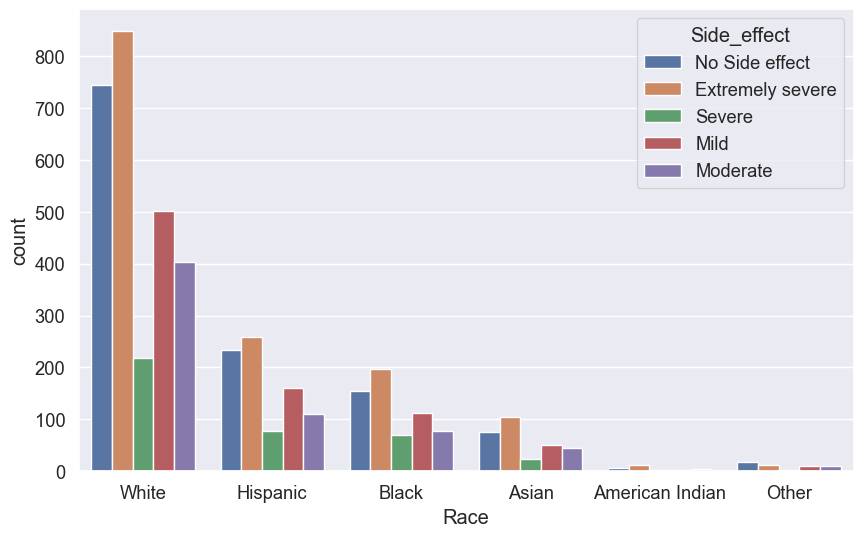

In [117]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Race',hue='Side_effect',data=data2)

White and Hispanic users reported more extreme side effects

<Axes: xlabel='Drug', ylabel='count'>

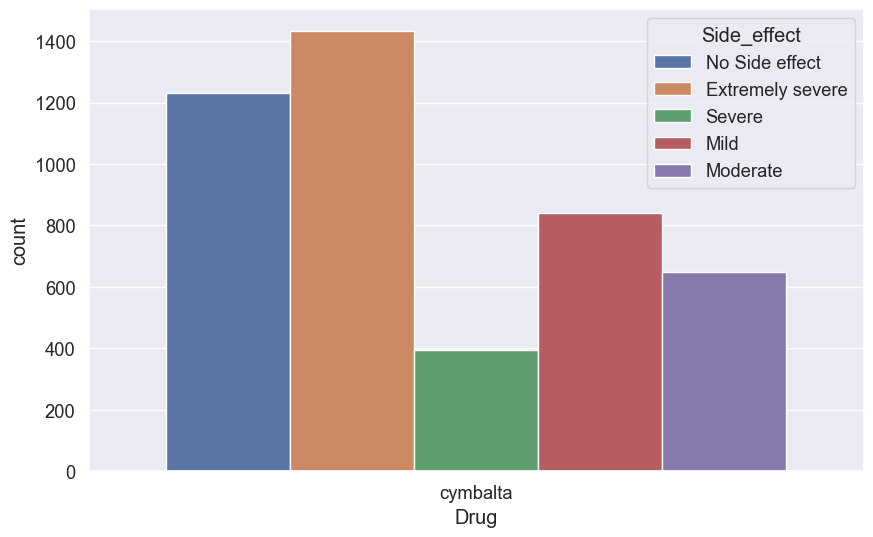

In [118]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Drug',hue='Side_effect',data=data2)

Let us the clean the reviews specific to our drug

In [119]:
data2["Reviews"] = data2["Reviews"].apply(clean_review)

Let us the rank the reviews by creating a function for the same

In [120]:
def predict_rank(text):
    cleaned_text = [clean_review(text)]
    vectorized_text = vectorizer.transform(cleaned_text)
    pred = model.predict(vectorized_text)[0]
    if (pred == 0):
        return 0
    else :
        return 1
    
def predict_rank1(rank):
    if (rank < 3):
        return 0
    else:
        return 1

data2['Reviews_Rank'] = data2['Satisfaction']
data2.loc[data2['Satisfaction'] < 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] < 3, 'Reviews_Rank'].apply(predict_rank1)
data2.loc[data2['Satisfaction'] > 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] > 3, 'Reviews_Rank'].apply(predict_rank1)
data2.loc[data2['Satisfaction'] == 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] == 3, 'Reviews'].apply(predict_rank)

print(data2['Reviews_Rank'].unique())
#example
predict_rank("I loved it")

[1. 0.]


1

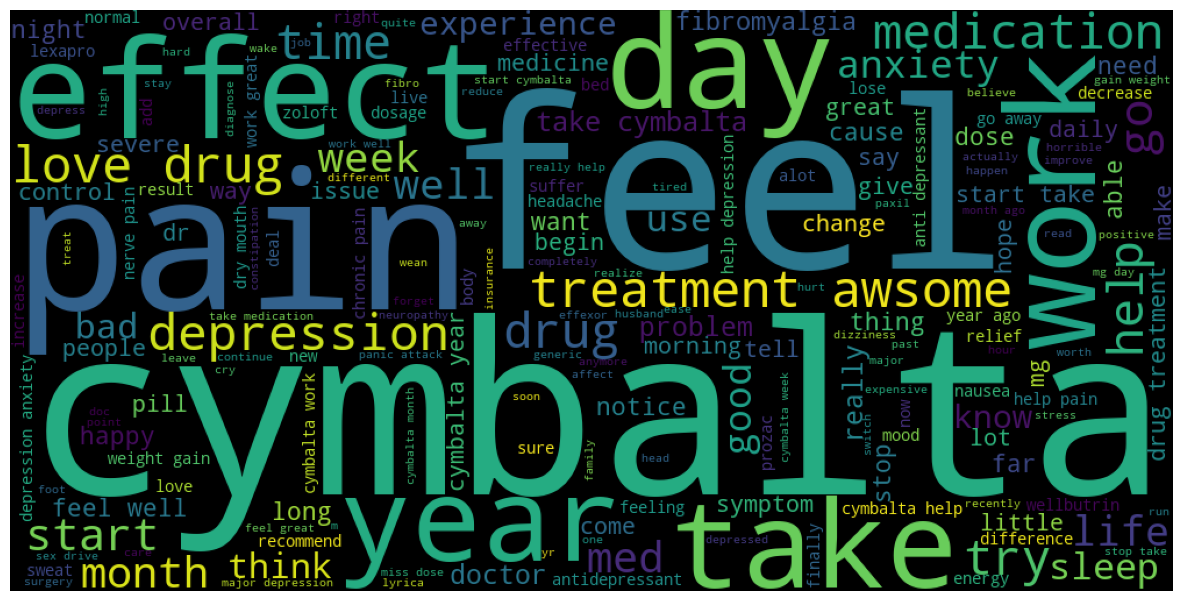

In [121]:
# Word cloud of the Clean reviews with +ve sentiments
neg_rate_review = data2.loc[data2['Reviews_Rank'] == 1., 'Reviews']
k = (' '.join(neg_rate_review))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

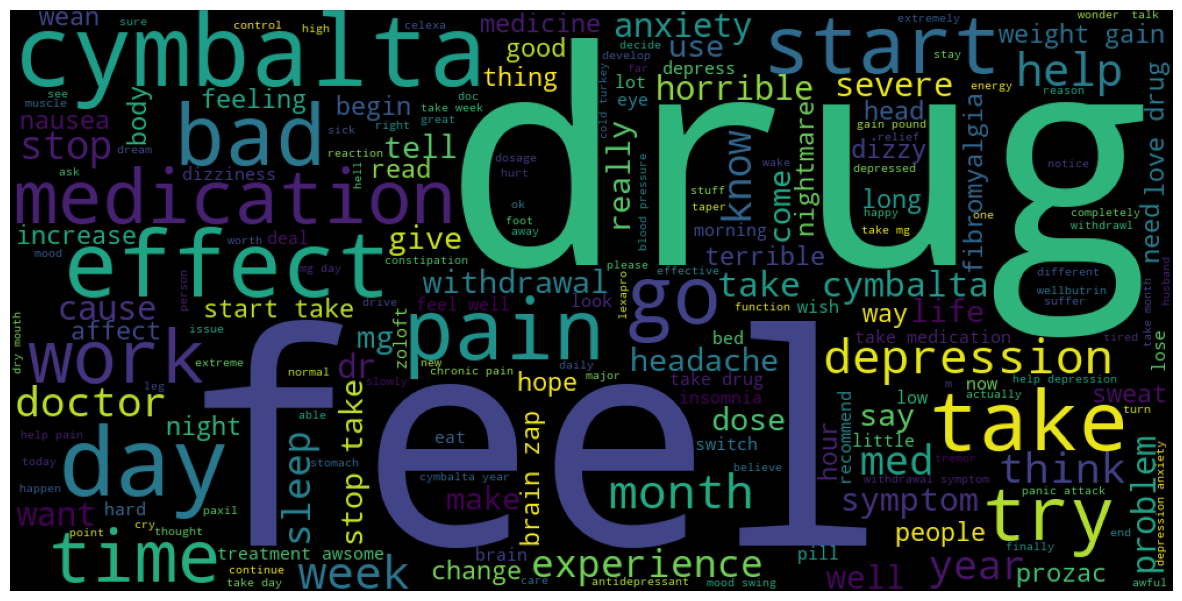

In [122]:
# Word cloud of the Clean reviews with -ve sentiments
neg_rate_review = data2.loc[data2['Reviews_Rank'] == 0., 'Reviews']
k = (' '.join(neg_rate_review))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

In [123]:
data2.head()

Name      Race    Age                               Condition  \
314212      Archie     White   7-12               Major Depressive Disorder   
314216  Georgianne     White  45-54            Repeated Episodes of Anxiety   
314223        Josh  Hispanic  45-54  Anxiousness associated with Depression   
314235        Suzi     White  35-44  Anxiousness associated with Depression   
314246     Margert     Black  55-64             Chronic Muscle or Bone Pain   

             Date      Drug   DrugId  EaseofUse  Effectiveness  \
314212 2020-02-29  cymbalta  91491.0        5.0            5.0   
314216 2020-01-13  cymbalta  91491.0        3.0            1.0   
314223 2020-01-04  cymbalta  91491.0        5.0            5.0   
314235 2019-12-06  cymbalta  91491.0        3.0            3.0   
314246 2019-11-20  cymbalta  91491.0        2.0            2.0   

                                                  Reviews  Satisfaction  \
314212  no script health insurance need place order di...           5.0   
314216  i prescribe cymbalta anxiety start low dosage ...           1.0   
314223  switch effexor medicine year no issue transiti...           5.0   
314235  bipolar i neck fusion pdoc prescribe depressio...           2.0   
314246  i depression anxiety fibro severe muscle spasm...           2.0   

        Gender                                              Sides  \
314212  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314216    Male  Nausea ,  dry mouth ,  constipation , loss of ...   
314223  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314235  Female  Nausea ,  dry mouth ,  constipation , loss of ...   
314246  Female  Nausea ,  dry mouth ,  constipation , loss of ...   

        UsefulCount       Side_effect  Year  Month day_of_the_week  \
314212         12.0    No Side effect  2020      2        Saturday   
314216          0.0  Extremely severe  2020      1          Monday   
314223          0.0    No Side effect  2020      1        Saturday   
314235          0.0            Severe  2019     12          Friday   
314246          1.0            Severe  2019     11       Wednesday   

        Reviews_Rank  
314212           1.0  
314216           0.0  
314223           1.0  
314235           0.0  
314246           0.0

In [124]:
#Convert symptoms into numeric data
data1['Sides']=pd.factorize(data1['Sides'])[0]

In [125]:
fact_pkl=open('fact.pkl','wb')
pickle.dump(data1['Sides'],fact_pkl)
fact_pkl.close()

Columns Name has unique values so will be dropped.Drug, DrugId, Date, Easeofuse, usefulcount,Month,Dayofweek will be dropped.Age, Race, Gender will be encoded. Satisfaction will be segregated based on the values as no, mild, moderate, severe, extreme based on values of 5, 4, 3, 2, 1 respectively. The assumption being that the satisfaction is a parameter that gets affected by side effects in case of patients.

In [126]:
data2.drop(['Name','Condition','Date','Drug','DrugId','Sides','EaseofUse','UsefulCount','Month','day_of_the_week','Reviews'], axis=1, inplace = True)

In [127]:
data2.head(15)

Race         Age  Effectiveness  Satisfaction  Gender  \
314212     White        7-12            5.0           5.0  Female   
314216     White       45-54            1.0           1.0    Male   
314223  Hispanic       45-54            5.0           5.0  Female   
314235     White       35-44            3.0           2.0  Female   
314246     Black       55-64            2.0           2.0  Female   
314257     White       55-64            3.0           1.0  Female   
314267     White       45-54            4.0           4.0  Female   
314281     White       19-24            1.0           1.0    Male   
314292     Black       45-54            1.0           1.0  Female   
314305     White       55-64            4.0           4.0    Male   
314315     Asian       35-44            5.0           4.0  Female   
314323     White  75 or over            5.0           5.0  Female   
314329     White       55-64            5.0           3.0  Female   
314334  Hispanic  75 or over            1.0           1.0  Female   
314341  Hispanic       55-64            3.0           3.0  Female   

             Side_effect  Year  Reviews_Rank  
314212    No Side effect  2020           1.0  
314216  Extremely severe  2020           0.0  
314223    No Side effect  2020           1.0  
314235            Severe  2019           0.0  
314246            Severe  2019           0.0  
314257  Extremely severe  2019           0.0  
314267              Mild  2019           1.0  
314281  Extremely severe  2019           0.0  
314292  Extremely severe  2019           0.0  
314305              Mild  2019           1.0  
314315              Mild  2019           1.0  
314323    No Side effect  2019           1.0  
314329          Moderate  2014           0.0  
314334  Extremely severe  2014           0.0  
314341          Moderate  2014           0.0

In [128]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4548 entries, 314212 to 399807
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Race           4548 non-null   object 
 1   Age            4548 non-null   object 
 2   Effectiveness  4548 non-null   float64
 3   Satisfaction   4548 non-null   float64
 4   Gender         4548 non-null   object 
 5   Side_effect    4548 non-null   object 
 6   Year           4548 non-null   int64  
 7   Reviews_Rank   4548 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 319.8+ KB


In [129]:
data2['Age'].unique()

array(['7-12', '45-54', '35-44', '55-64', '19-24', '75 or over', '65-74',
       '13-18', '25-34', '3-6', '0-2'], dtype=object)

In [130]:
data2['Age'].value_counts()

45-54         1370
55-64          993
35-44          856
25-34          590
65-74          396
19-24          212
75 or over      93
13-18           35
7-12             1
3-6              1
0-2              1
Name: Age, dtype: int64

Label Encoding

In [131]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le1=LabelEncoder()
le2=LabelEncoder()
le3=LabelEncoder()

data2['Race']=le.fit_transform(data2['Race'])
data2['Age']=le1.fit_transform(data2['Age'])
data2['Side_effect']=le2.fit_transform(data2['Side_effect'])
data2['Gender']=le3.fit_transform(data2['Gender'])

Scaling

In [132]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
data2['Effectiveness'] = scaler1.fit_transform(data2[['Effectiveness']])

data2['Satisfaction'] = scaler2.fit_transform(data2[['Satisfaction']])

data2['Reviews_Rank'] = scaler3.fit_transform(data2[['Reviews_Rank']])


In [133]:
data2.head(10)

Race  Age  Effectiveness  Satisfaction  Gender  Side_effect  Year  \
314212     5    9           1.00          1.00       0            3  2020   
314216     5    6           0.00          0.00       1            0  2020   
314223     3    6           1.00          1.00       0            3  2020   
314235     5    5           0.50          0.25       0            4  2019   
314246     2    7           0.25          0.25       0            4  2019   
314257     5    7           0.50          0.00       0            0  2019   
314267     5    6           0.75          0.75       0            1  2019   
314281     5    2           0.00          0.00       1            0  2019   
314292     2    6           0.00          0.00       0            0  2019   
314305     5    7           0.75          0.75       1            1  2019   

        Reviews_Rank  
314212           1.0  
314216           0.0  
314223           1.0  
314235           0.0  
314246           0.0  
314257           0.0  
314267           1.0  
314281           0.0  
314292           0.0  
314305           1.0

In [134]:
#Splitting the data into independent and dependent variables
X=data2.drop(['Side_effect'], axis=1)
y=data2['Side_effect']

In [135]:
X

Race  Age  Effectiveness  Satisfaction  Gender  Year  Reviews_Rank
314212     5    9           1.00          1.00       0  2020           1.0
314216     5    6           0.00          0.00       1  2020           0.0
314223     3    6           1.00          1.00       0  2020           1.0
314235     5    5           0.50          0.25       0  2019           0.0
314246     2    7           0.25          0.25       0  2019           0.0
...      ...  ...            ...           ...     ...   ...           ...
399417     2    6           0.00          0.00       0  2013           0.0
399545     3    3           1.00          0.75       1  2010           1.0
399630     3    5           1.00          1.00       0  2011           1.0
399791     5    8           0.75          0.75       0  2014           1.0
399807     5    5           0.25          0.25       0  2012           0.0

[4548 rows x 7 columns]

In [136]:
y

314212    3
314216    0
314223    3
314235    4
314246    4
         ..
399417    0
399545    1
399630    3
399791    1
399807    4
Name: Side_effect, Length: 4548, dtype: int32

In [137]:
#splitting the data into train,validation
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state=42)

In [138]:
print(X_train.shape),print(y_train.shape)
print(X_test.shape),print(y_test.shape)

(3638, 7)
(3638,)
(910, 7)
(910,)


(None, None)

######  Modeling and  Evaluation

In [139]:
#Naive Bayes, Support Vector Machines (SVM), Random Forest,KNN,Linear Support Vector Machine,Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       282
           1       0.69      0.75      0.72       163
           2       0.68      0.40      0.50       133
           3       0.91      0.96      0.93       257
           4       0.41      0.43      0.42        75

    accuracy                           0.79       910
   macro avg       0.71      0.70      0.70       910
weighted avg       0.78      0.79      0.78       910



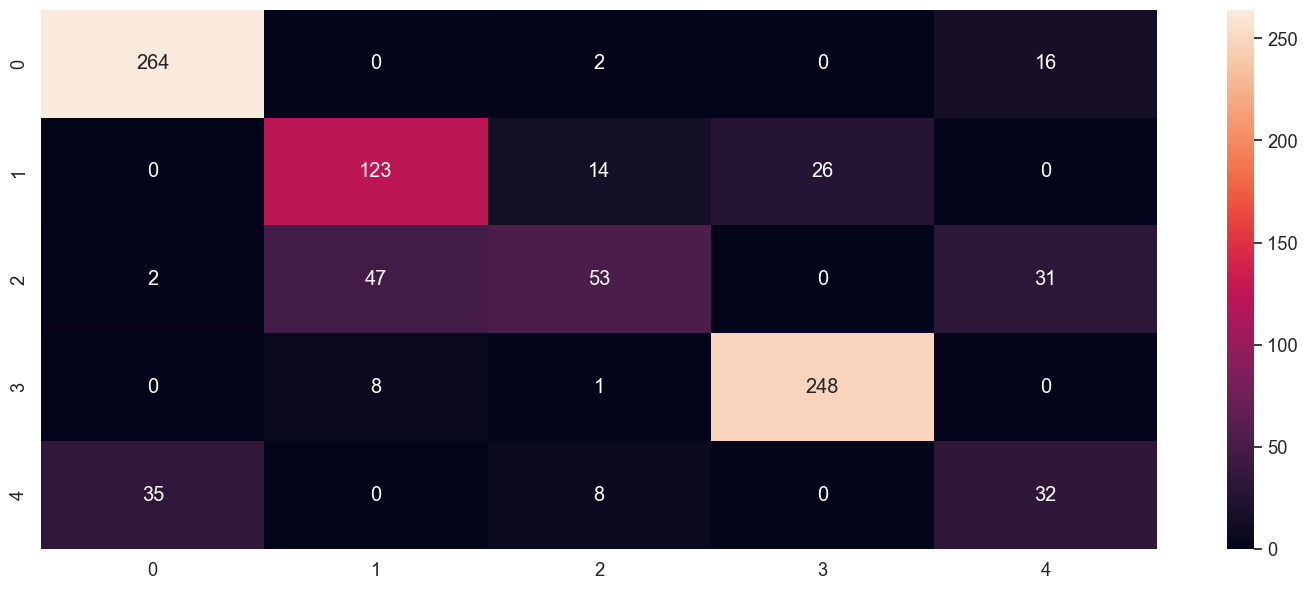

In [140]:
#1.using LogisticRegression
log_reg=LogisticRegression()
model = log_reg.fit(X_train,y_train)
log_pred = model.predict(X_test)
cm=confusion_matrix(y_test,log_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00       133
           3       1.00      1.00      1.00       257
           4       1.00      1.00      1.00        75

    accuracy                           1.00       910
   macro avg       1.00      1.00      1.00       910
weighted avg       1.00      1.00      1.00       910



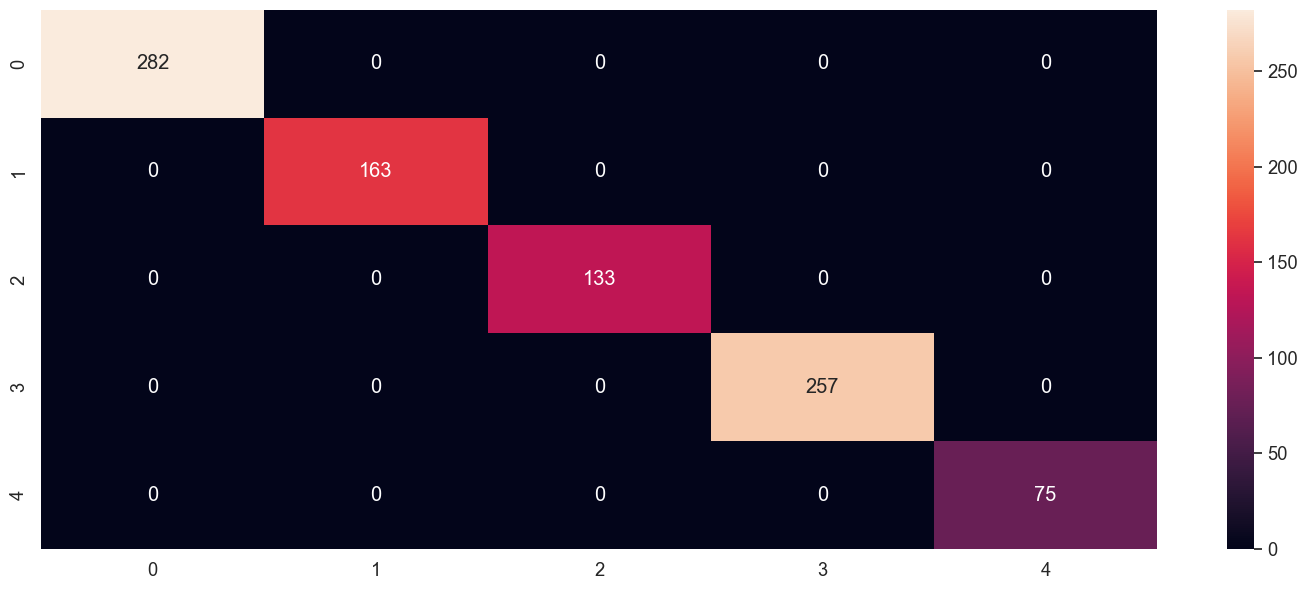

In [141]:
#2.using RandomForestClassifier
rf_clf=RandomForestClassifier()
model = rf_clf.fit(X_train,y_train)
rf_pred = model.predict(X_test)
cm=confusion_matrix(y_test,rf_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,rf_pred))


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       282
           1       0.71      0.83      0.76       163
           2       0.67      0.38      0.49       133
           3       0.89      0.90      0.90       257
           4       0.68      0.36      0.47        75

    accuracy                           0.79       910
   macro avg       0.75      0.69      0.70       910
weighted avg       0.78      0.79      0.77       910



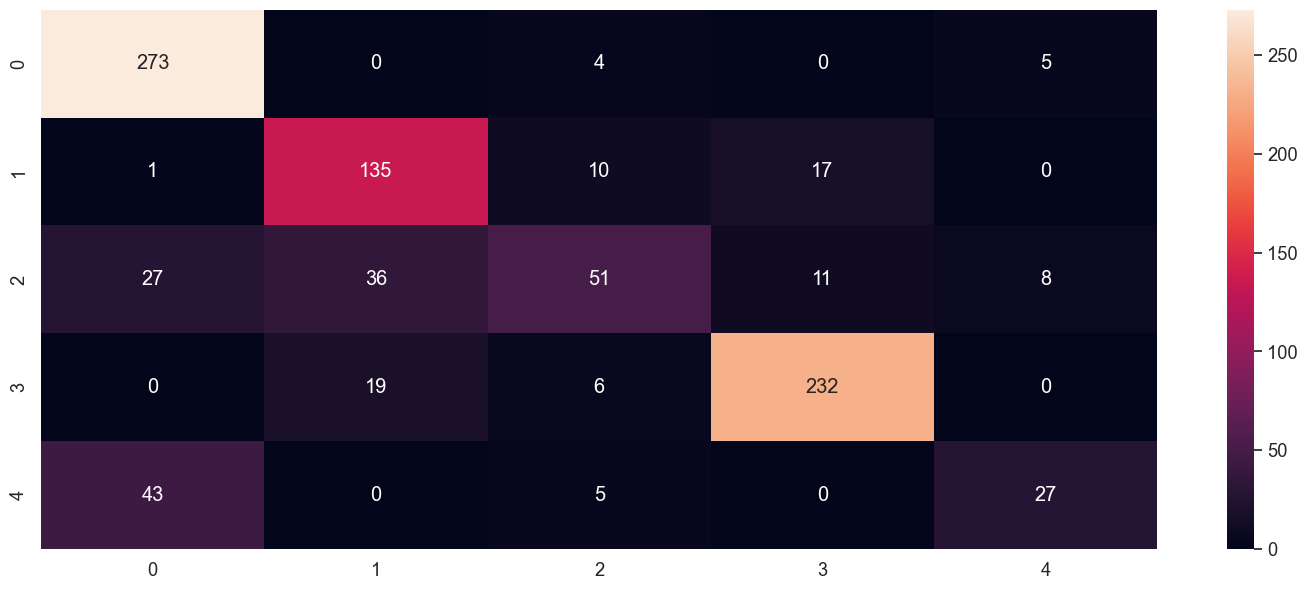

In [142]:
#3.using KNeighborsClassifier
knn_clf=KNeighborsClassifier()
model = knn_clf.fit(X_train,y_train)
knn_pred = model.predict(X_test)
cm=confusion_matrix(y_test,knn_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       282
           1       0.25      0.05      0.08       163
           2       1.00      0.02      0.04       133
           3       0.51      1.00      0.68       257
           4       0.60      0.43      0.50        75

    accuracy                           0.64       910
   macro avg       0.65      0.50      0.45       910
weighted avg       0.66      0.64      0.54       910



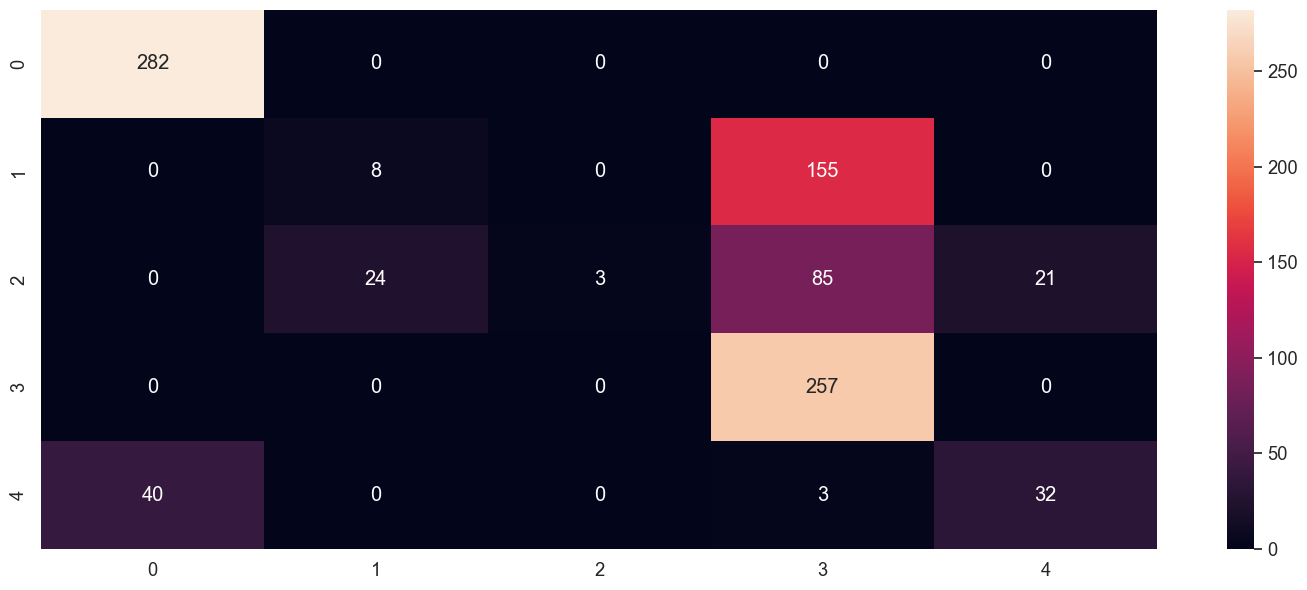

In [143]:
#4.using MultinomialNB Naive Bayes 
nb= MultinomialNB()
model = nb.fit(X_train,y_train)
nb_pred = model.predict(X_test)
cm=confusion_matrix(y_test,nb_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.31      1.00      0.47       282
           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00       133
           3       0.00      0.00      0.00       257
           4       0.00      0.00      0.00        75

    accuracy                           0.31       910
   macro avg       0.06      0.20      0.09       910
weighted avg       0.10      0.31      0.15       910



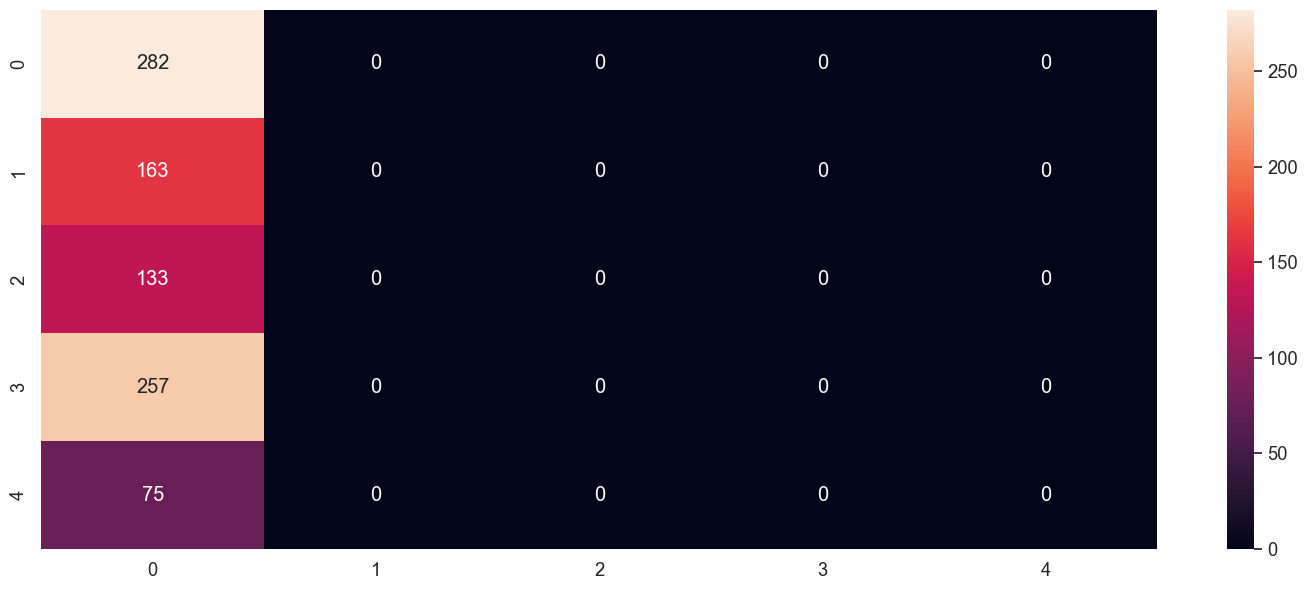

In [144]:
#5.using Support Vector Machines
svm = SVC()
model = svm.fit(X_train,y_train)
svm_pred = model.predict(X_test)
cm=confusion_matrix(y_test,svm_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00       133
           3       1.00      1.00      1.00       257
           4       1.00      1.00      1.00        75

    accuracy                           1.00       910
   macro avg       1.00      1.00      1.00       910
weighted avg       1.00      1.00      1.00       910



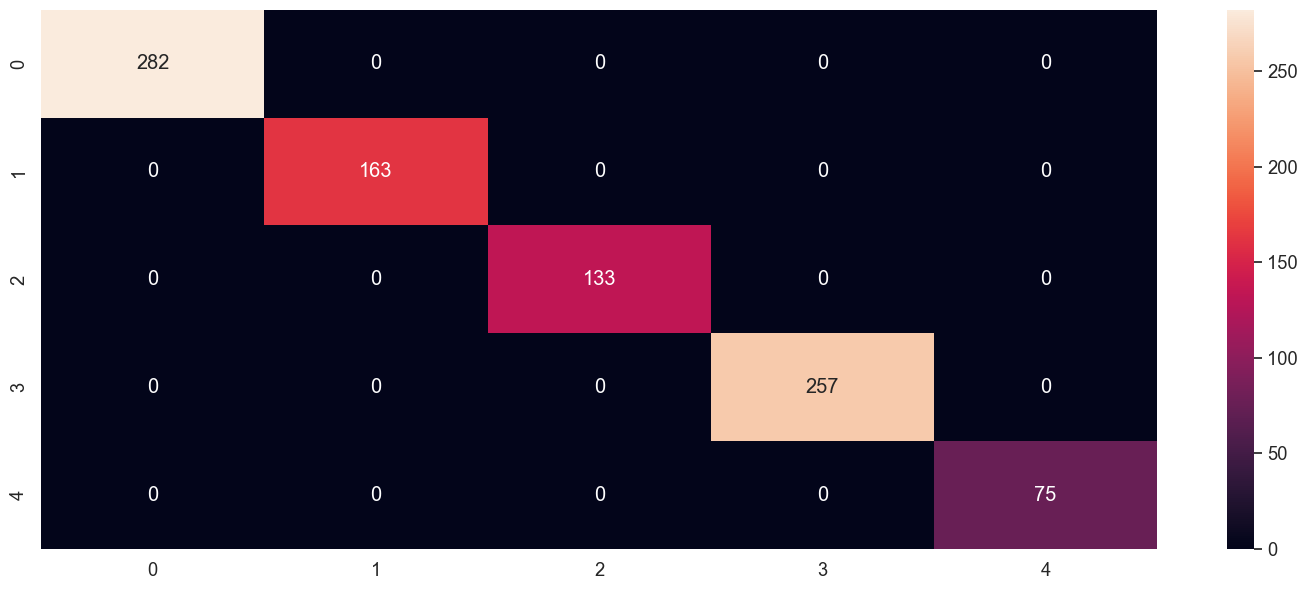

In [145]:
#6.using XGBClassifier
xg_clf = XGBClassifier()
model = xg_clf.fit(X_train,y_train)
xg_pred = model.predict(X_test)
cm=confusion_matrix(y_test,xg_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,xg_pred))

Learning rate set to 0.084514
0:	learn: 1.3063037	total: 166ms	remaining: 2m 46s
1:	learn: 1.0963845	total: 169ms	remaining: 1m 24s
2:	learn: 0.9430996	total: 172ms	remaining: 57s
3:	learn: 0.8195439	total: 174ms	remaining: 43.2s
4:	learn: 0.7193886	total: 175ms	remaining: 34.9s
5:	learn: 0.6381527	total: 177ms	remaining: 29.4s
6:	learn: 0.5667622	total: 179ms	remaining: 25.4s
7:	learn: 0.5077996	total: 181ms	remaining: 22.4s
8:	learn: 0.4568346	total: 183ms	remaining: 20.2s
9:	learn: 0.4111683	total: 186ms	remaining: 18.4s
10:	learn: 0.3712625	total: 188ms	remaining: 16.9s
11:	learn: 0.3357669	total: 190ms	remaining: 15.6s
12:	learn: 0.3048195	total: 192ms	remaining: 14.6s
13:	learn: 0.2772083	total: 194ms	remaining: 13.6s
14:	learn: 0.2523161	total: 196ms	remaining: 12.9s
15:	learn: 0.2305746	total: 198ms	remaining: 12.2s
16:	learn: 0.2100612	total: 200ms	remaining: 11.6s
17:	learn: 0.1924864	total: 202ms	remaining: 11s
18:	learn: 0.1762047	total: 204ms	remaining: 10.5s
19:	learn: 0.

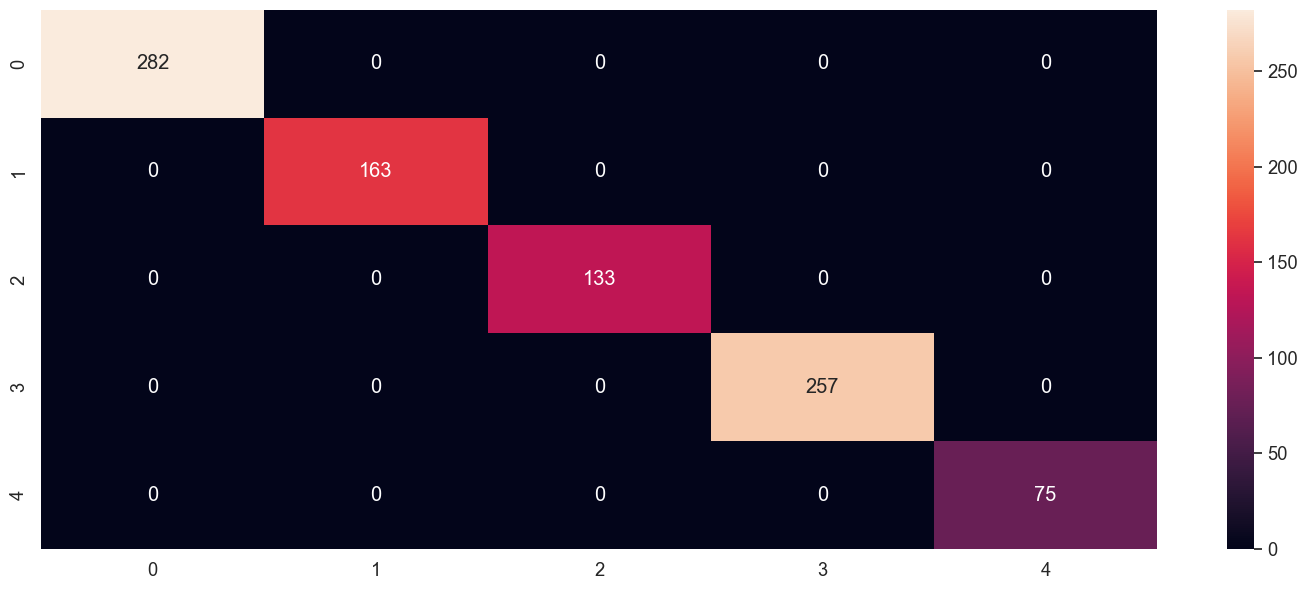

In [146]:
#7.using CatBoostClassifier
cb_clf = CatBoostClassifier()
model = cb_clf.fit(X_train,y_train)
cb_pred = model.predict(X_test)
cm=confusion_matrix(y_test,cb_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,cb_pred))

By seeing the result,CatBoostclassifier,RandomForestClassifier,XGBClassifier are the performing models.

Hyperparameter Tuning with RandomSearch for above 3 algorithms

In [147]:
params = {
    
    'RandomForestClassifier' : {
        'model' : RandomForestClassifier(),
        'param' : {
            'n_estimators' : [5, 100, 700, 1000, 2100],
            'max_depth' : [3, 5, 7, 9, 11, 13, 15],
            'max_features' : ["auto", "sqrt", "log2"],
            'min_samples_split' : [2, 4, 6, 8]
        }
    },
    
    
    'XGBoostClassifier'  :{
        'model' : XGBClassifier(),
        'param' :{
            'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
            'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
            'min_child_weight' : [ 1, 3, 5, 7 ],
            'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
            
               }
                           
    },
    'CatBoostClassifier'  :{
        'model' : CatBoostClassifier(),
        'param' :{
            'learning_rate': [0.03, 0.1],
            'depth': [4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]
             }
                           
    }
    
} 

In [148]:
from sklearn.model_selection import RandomizedSearchCV
scores = []

for name, mp in params.items():
    rs = RandomizedSearchCV(estimator=mp['model'], param_distributions=mp['param'], cv = 5, verbose=3, n_jobs=-1)
    rs.fit(X_train, y_train)
    scores.append({
        'model' : name,
        'score' : rs.best_score_,
        'estimator' : rs.best_estimator_
    })

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 1.5039301	total: 5.94ms	remaining: 5.93s
1:	learn: 1.4209866	total: 18.3ms	remaining: 9.15s
2:	learn: 1.3313482	total: 22.7ms	remaining: 7.56s
3:	learn: 1.2517193	total: 26.5ms	remaining: 6.6s
4:	learn: 1.1822519	total: 30.6ms	remaining: 6.09s
5:	learn: 1.1174041	total: 33.8ms	remaining: 5.6s
6:	learn: 1.0575273	total: 36.7ms	remaining: 5.21s
7:	learn: 1.0048766	total: 43.9ms	remaining: 5.45s
8:	learn: 0.9551051	total: 47.5ms	remaining: 5.23s
9:	learn: 0.9134032	total: 57ms	remaining: 5.64s
10:	learn: 0.8701395	total: 60.6ms	remaining: 5.45s
11:	learn: 0.8303945	total: 64.7ms	remaining: 5.32s
12:	learn: 0.7928282	total: 68.2ms	remaining: 5.18s
13:	learn: 0.7584929	total: 73.3ms	remaining: 5.16s
14:	learn: 0.7256931	total: 77ms	remaining: 5.06s
15:	learn: 0.6954304	total: 81.3ms	remaining: 5s
16:	

In [149]:
final = pd.DataFrame(scores, columns=['model', 'score', 'estimator'])
final.sort_values('score', ascending=False)

model  score  \
0  RandomForestClassifier    1.0   
1       XGBoostClassifier    1.0   
2      CatBoostClassifier    1.0   

                                           estimator  
0  (DecisionTreeClassifier(max_depth=7, max_featu...  
1  XGBClassifier(base_score=None, booster=None, c...  
2  <catboost.core.CatBoostClassifier object at 0x...

###### Conclusion

Chose XGBClassifier model

In [150]:
final['estimator'].iloc[1]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00       133
           3       1.00      1.00      1.00       257
           4       1.00      1.00      1.00        75

    accuracy                           1.00       910
   macro avg       1.00      1.00      1.00       910
weighted avg       1.00      1.00      1.00       910



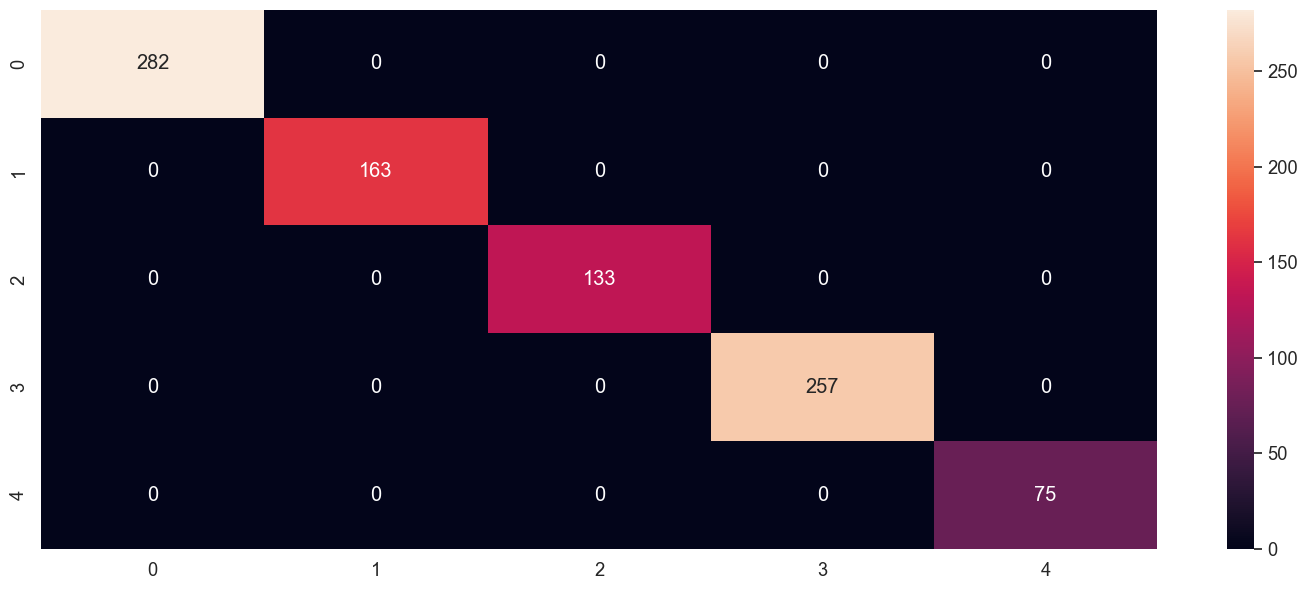

In [151]:
# Using the best parameters of XGBClassifier for building the final model

xgb = XGBClassifier(colsample_bytree=0.3,gamma=0.0,learning_rate=0.5,max_depth=12,min_child_weight=1,n_estimators=100)
xgb.fit(X_train, y_train)
xg_pred = xgb.predict(X_test)
cm=confusion_matrix(y_test,xg_pred)
sns.heatmap(cm,annot=True,fmt="d")
print(classification_report(y_test,xg_pred))

Pickling

In [152]:
XGB_pkl = open('XGB.pkl','wb')
pickle.dump(xgb,XGB_pkl)
XGB_pkl.close()

In [153]:
ler_pkl=open('ler.pkl','wb')
pickle.dump(le,ler_pkl)
ler_pkl.close()

lea_pkl=open('lea.pkl','wb')
pickle.dump(le1,lea_pkl)
lea_pkl.close()

let_pkl=open('let.pkl','wb')
pickle.dump(le2,let_pkl)
let_pkl.close()

leg_pkl=open('leg.pkl','wb')
pickle.dump(le3,leg_pkl)
leg_pkl.close()

In [154]:
sce_pkl=open('sce.pkl','wb')
pickle.dump(scaler1,sce_pkl)
sce_pkl.close()

scs_pkl=open('scs.pkl','wb')
pickle.dump(scaler2,scs_pkl)
scs_pkl.close()

scr_pkl=open('scr.pkl','wb')
pickle.dump(scaler3,scr_pkl)
scr_pkl.close()